In [309]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import requests

from bs4 import BeautifulSoup as soup
import BcBData

import matplotlib.pyplot as plt # PLOTS
from matplotlib import cm # PALETAS DE CORES MATPLOTLIB
plt.rcParams['figure.figsize'] = (15, 8) # TAMANHO DA FIGURA
plt.rcParams["figure.dpi"] = 300 # DPI DA FIGURA
plt.style.use('seaborn-white') # ESTILO DE PLOT (FUNDO BRANCO)

In [84]:
### OBTER LISTA DE FIIs listados

r = requests.get('https://www.fundsexplorer.com.br/funds')
s = soup(r.content, 'html.parser')

containers = s.find_all('div', {'class': 'item'})

fiis_list = [c['id'].replace('item-', '') for c in containers]
len(fiis_list)

330

In [16]:
def _correct_dates(date: str) -> str:
    '''Função para corrigir o vetor de datas extráido do site.
    '''
    
    ref_dict = {'Janeiro': '01', 'Fevereiro': '02', 'Março': '03', 'Abril': 
                '04', 'Maio': '05', 'Junho': '06', 'Julho': '07', 'Agosto': '08', 
                'Setembro': '09', 'Outubro': '10', 'Novembro': '11', 'Dezembro': '12'}

    date = date.replace('"', '')
    date_splits = date.split('/')

    date = date_splits[1] + '-' + ref_dict[date_splits[0]] 

    return date

In [186]:
class FundsExplorerAsset:
    def __init__(self, ticker: str):
        self.ticker = ticker
        self.get_dividends()
        self.get_prices()
        self.get_final_df()

    def get_dividends(self):
        url = 'https://www.fundsexplorer.com.br/funds/{}'

        r = requests.get(url.format(self.ticker))
        s = soup(r.content, 'html.parser')
        
        data = str(s.find_all('div', {'id': 'dividends-chart-wrapper'})[0].script)
        n1_date = data.find('data: {"labels":')
        n2_date = data.find(']')
        dates = data[n1_date:n2_date].split(',')[1:]

        n1_divs = data.find('"label":"Dividendos"')
        n2_divs = data.find(']', n1_divs)

        divs = data[n1_divs:n2_divs].split(',')[2:]
        data_df = pd.DataFrame({'Data': dates, 'div': divs})

        data_df['Data'] = data_df['Data'].apply(_correct_dates)
        data_df['Data'] = pd.to_datetime(data_df['Data'], format='%Y-%m')
        data_df['div'] = pd.to_numeric(data_df['div'])

        self.divs = data_df.set_index('Data').copy()

    def get_prices(self):
        url = 'https://chart.fundsexplorer.com.br/{}/cotacoes/?periodo=max'

        r_prices = requests.get(url.format(self.ticker[:4]))

        prices_df = pd.DataFrame(r_prices.json()['stockReports'])
        prices_df['fec'] = pd.to_numeric(prices_df['fec'])
        prices_df['data'] = pd.to_datetime(prices_df['data'])
        prices_df = prices_df.rename(columns={'data': 'Data'})

        self.prices = prices_df.copy()
        self.divs = self.divs.reindex(self.prices['Data'], method='ffill')
        self.prices_month = prices_df.set_index('Data')#.groupby(pd.Grouper(freq='MS')).mean()
    
    def get_final_df(self):
        #self.final_df = self.divs.merge(self.prices_month, left_index=True, right_index=True, how='outer')
        self.final_df = pd.concat([self.prices.set_index('Data'), self.divs], axis=1)

In [189]:
resultado = pd.DataFrame()
for fii in tqdm(fiis_list):
    try:
        x = FundsExplorerAsset(fii)

        t = x.final_df

        t['ticker'] = fii

        resultado = pd.concat([resultado, t])
    
    except Exception as e:
        pass

100%|██████████| 330/330 [05:45<00:00,  1.05s/it]


In [456]:
resultado = resultado.reset_index().drop_duplicates(['Data', 'ticker']).set_index('Data')
divs = resultado.pivot(values='div', columns='ticker').rolling(252).mean() * 12
divs = resultado.pivot(values='div', columns='ticker') * 12
V0 = resultado.pivot(values='fec', columns='ticker')

<AxesSubplot:title={'center':'Quantidade de FIIs\n(Dados válidos)'}, xlabel='Data'>

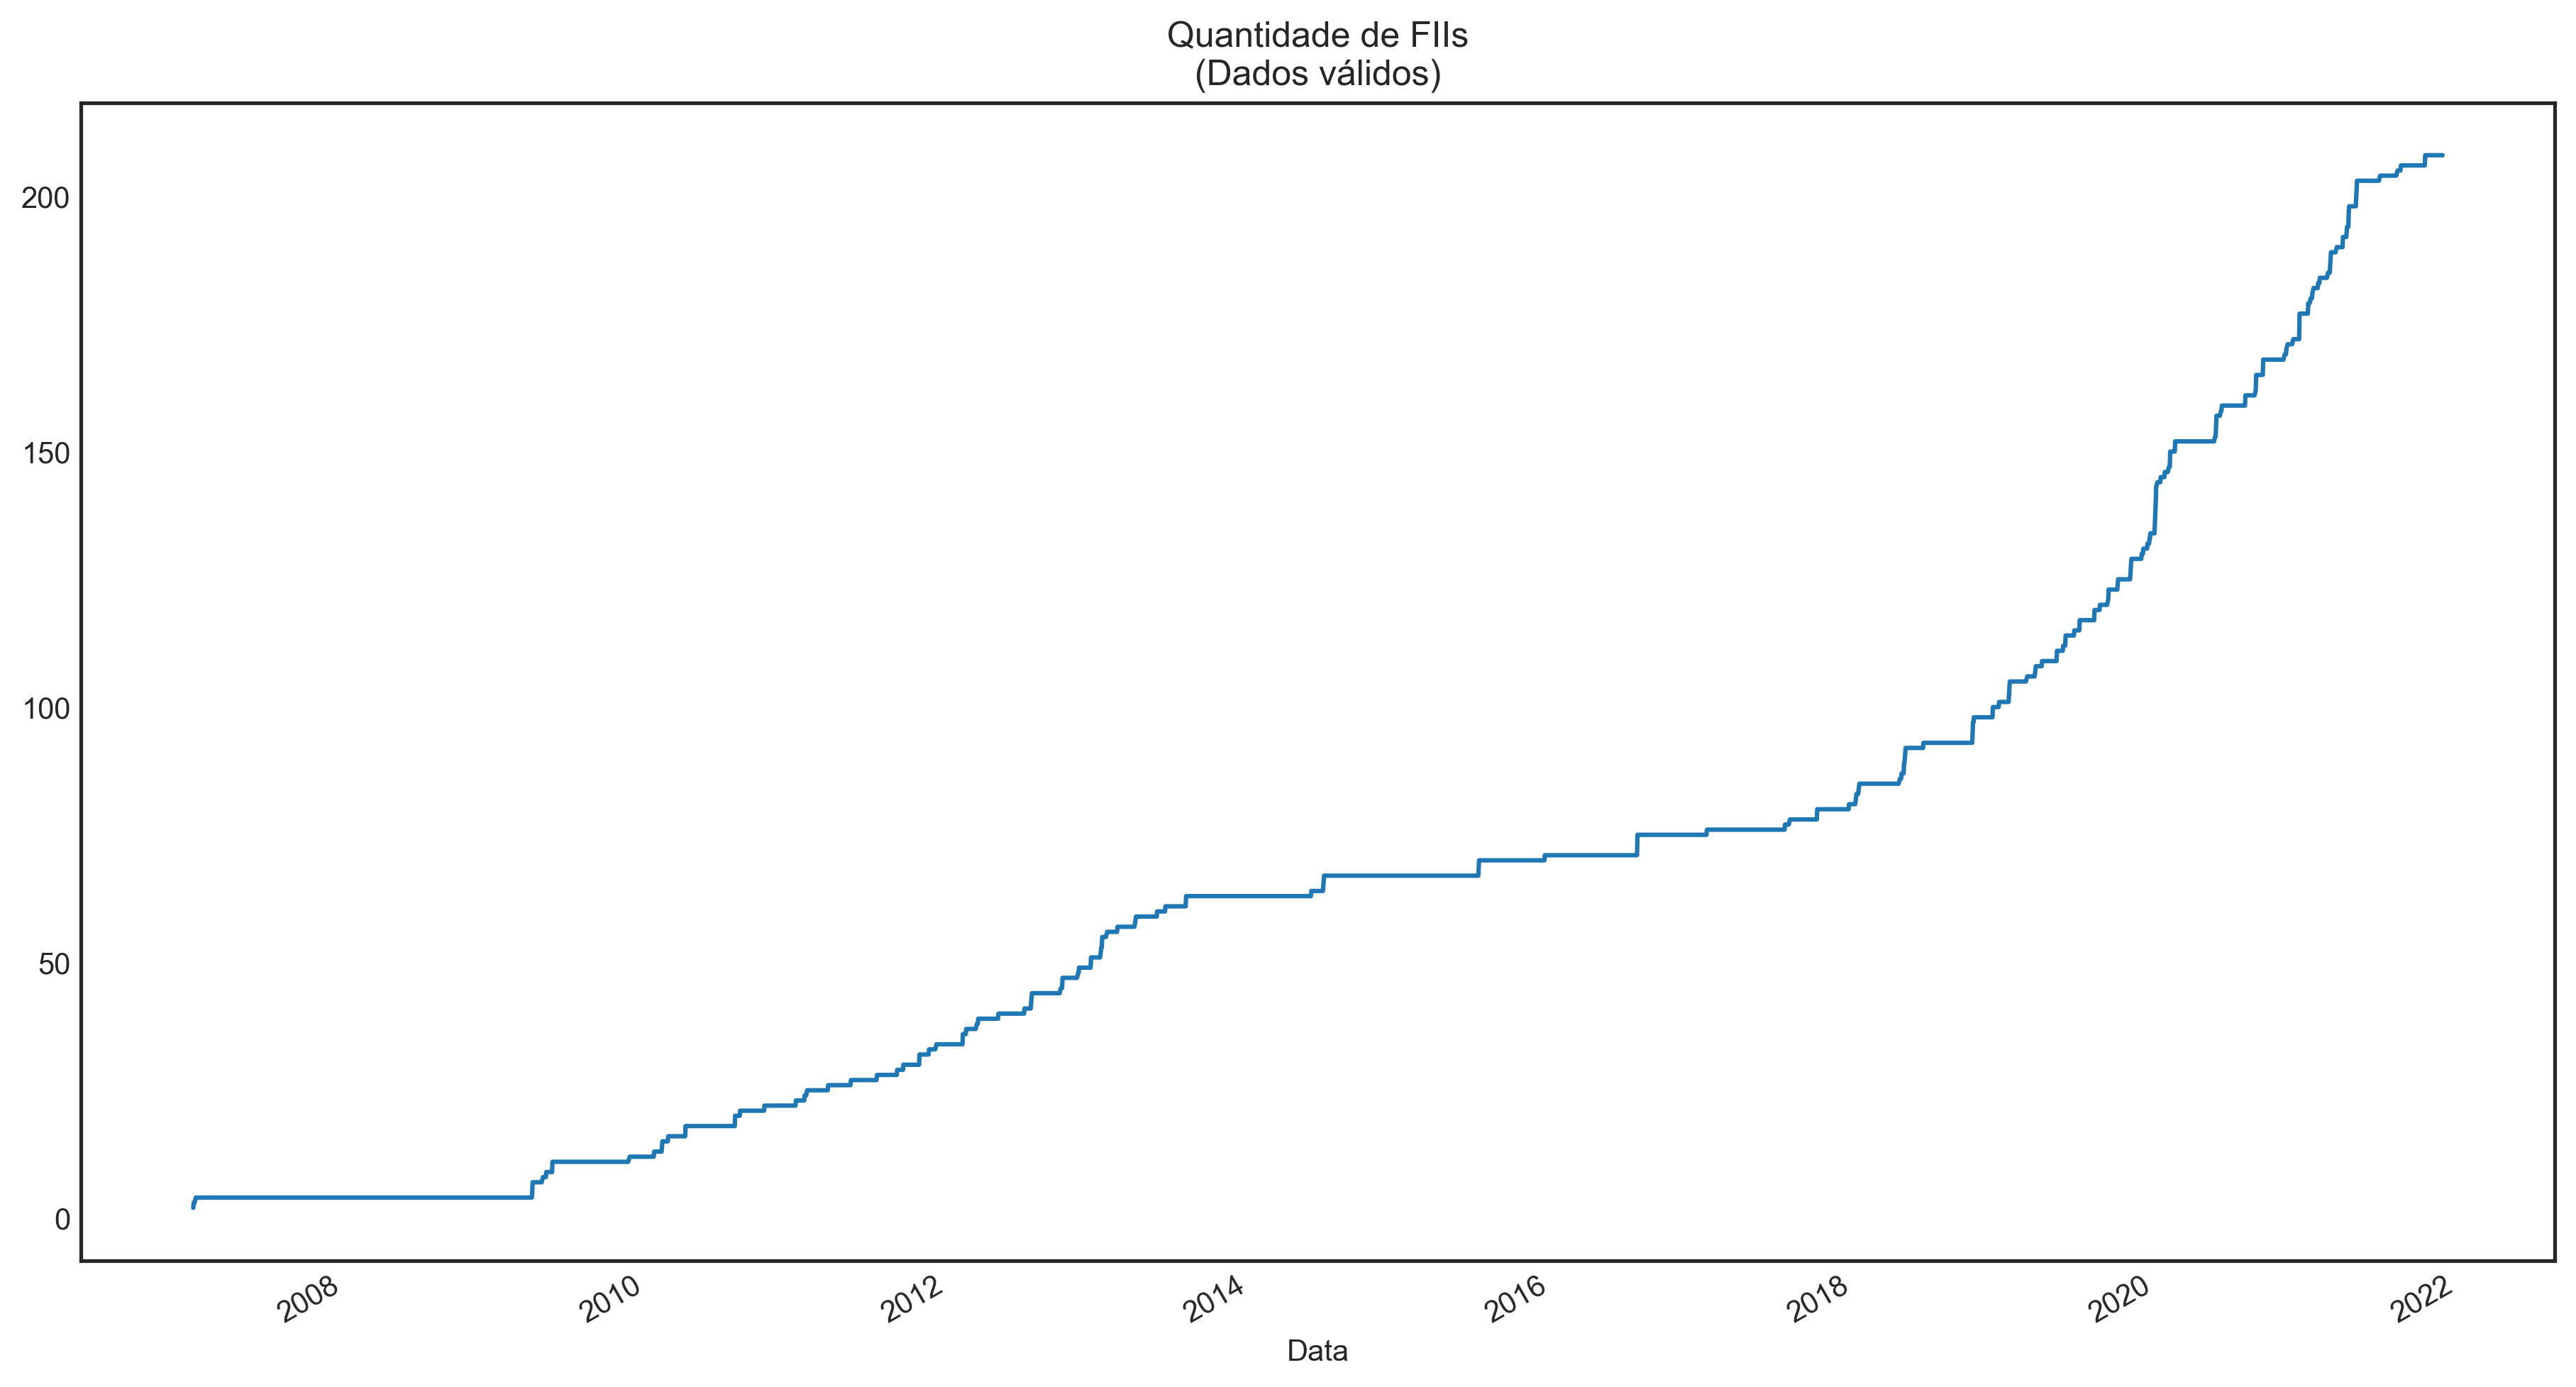

In [373]:
resultado.pivot(values='div', columns='ticker').count(1).cummax().plot(title='Quantidade de FIIs\n(Dados válidos)')

In [457]:
divs = divs.loc['2014-06':].copy()

In [458]:
ipca_expecs = BcBData.get_market_expectations('annual', Indicadores=['IPCA'], start='2014-06-01')
g = ipca_expecs.sort_values(['Data', 'DataReferencia']).drop_duplicates(['Data'], keep='last')[['Data', 'Mediana']]

In [550]:
g0 = ipca_expecs.sort_values(['Data', 'DataReferencia']).drop_duplicates(['Data'], keep='first')[['Data', 'Mediana']]

In [559]:
g0_df = pd.DataFrame(divs.index)
g0_df = g0_df.merge(g0, on='Data', how='left')
g0_df = g0_df.rename(columns={f'{g0_df.columns[1]}': 'g'})

for c in divs.columns:
    g0_df[c] = g0_df['g'].values

g0_df = g0_df.drop('g', axis=1)

g0_df = g0_df.set_index('Data')

In [553]:
g_df = pd.DataFrame(divs.index)
g_df = g_df.merge(g, on='Data', how='left')
g_df = g_df.rename(columns={f'{g_df.columns[1]}': 'g'})

for c in divs.columns:
    g_df[c] = g_df['g'].values

g_df = g_df.drop('g', axis=1)

g_df = g_df.set_index('Data')

In [560]:
D1 = divs * (1 + g0_df/100)
ke = D1/V0 + g_df/100

In [423]:
t10ys = pd.read_excel('DGS10.xls', skiprows=10)
t10ys = t10ys.rename(columns={'observation_date': 'Data'})
t10ys.loc[t10ys['DGS10']==0, 'DGS10'] = np.nan
t10ys['DGS10'] = t10ys['DGS10'].fillna(method='ffill')
t10ys['DGS10'] /= 100

In [561]:
ERP_df = pd.DataFrame(ke.median(1), columns=['ke'])
ERP_df = ERP_df.reset_index().merge(t10ys, on='Data', how='left').set_index('Data')
ERP_df['DGS10'] = ERP_df['DGS10'].fillna(method='ffill')
ERP_df = ERP_df.loc['2014-06':].copy()

# rf = 10-years U.S Treasury Bonds
ERP_df['ERP'] = ERP_df['ke'] - ERP_df['DGS10']

<AxesSubplot:title={'center':'10years Treasuries'}, xlabel='Data'>

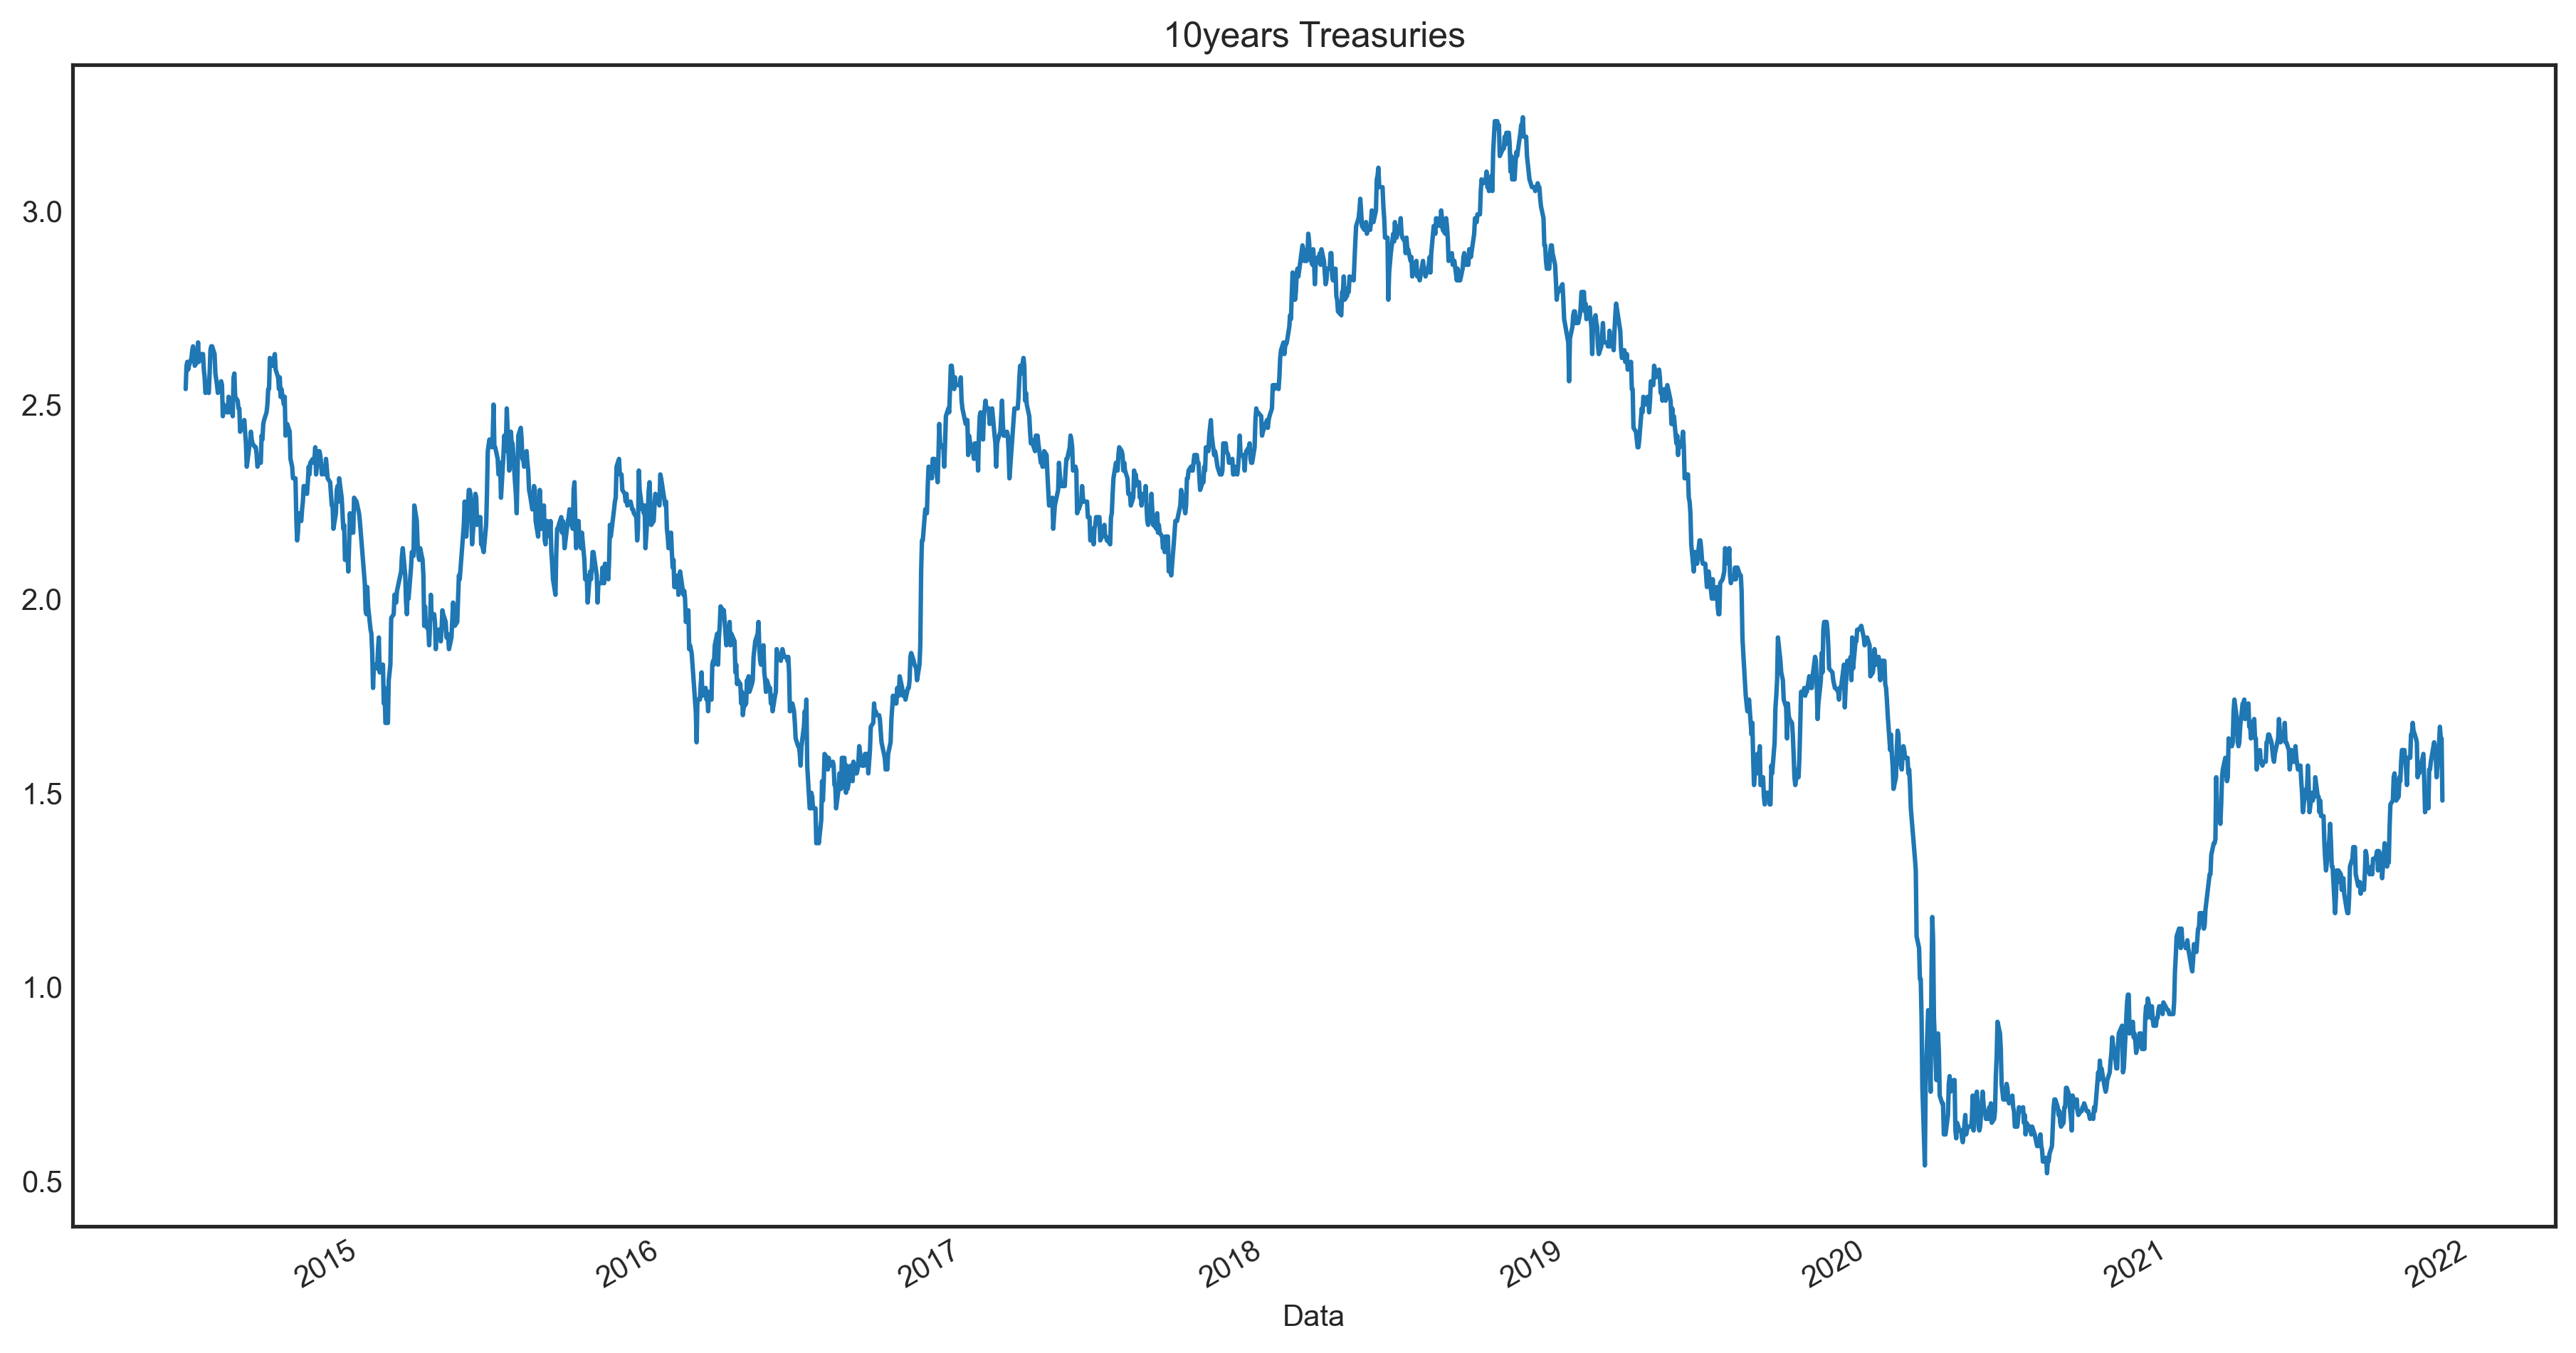

In [563]:
(ERP_df['DGS10'] * 100).plot(title='10years Treasuries')

Text(0, 0.5, 'ERP %')

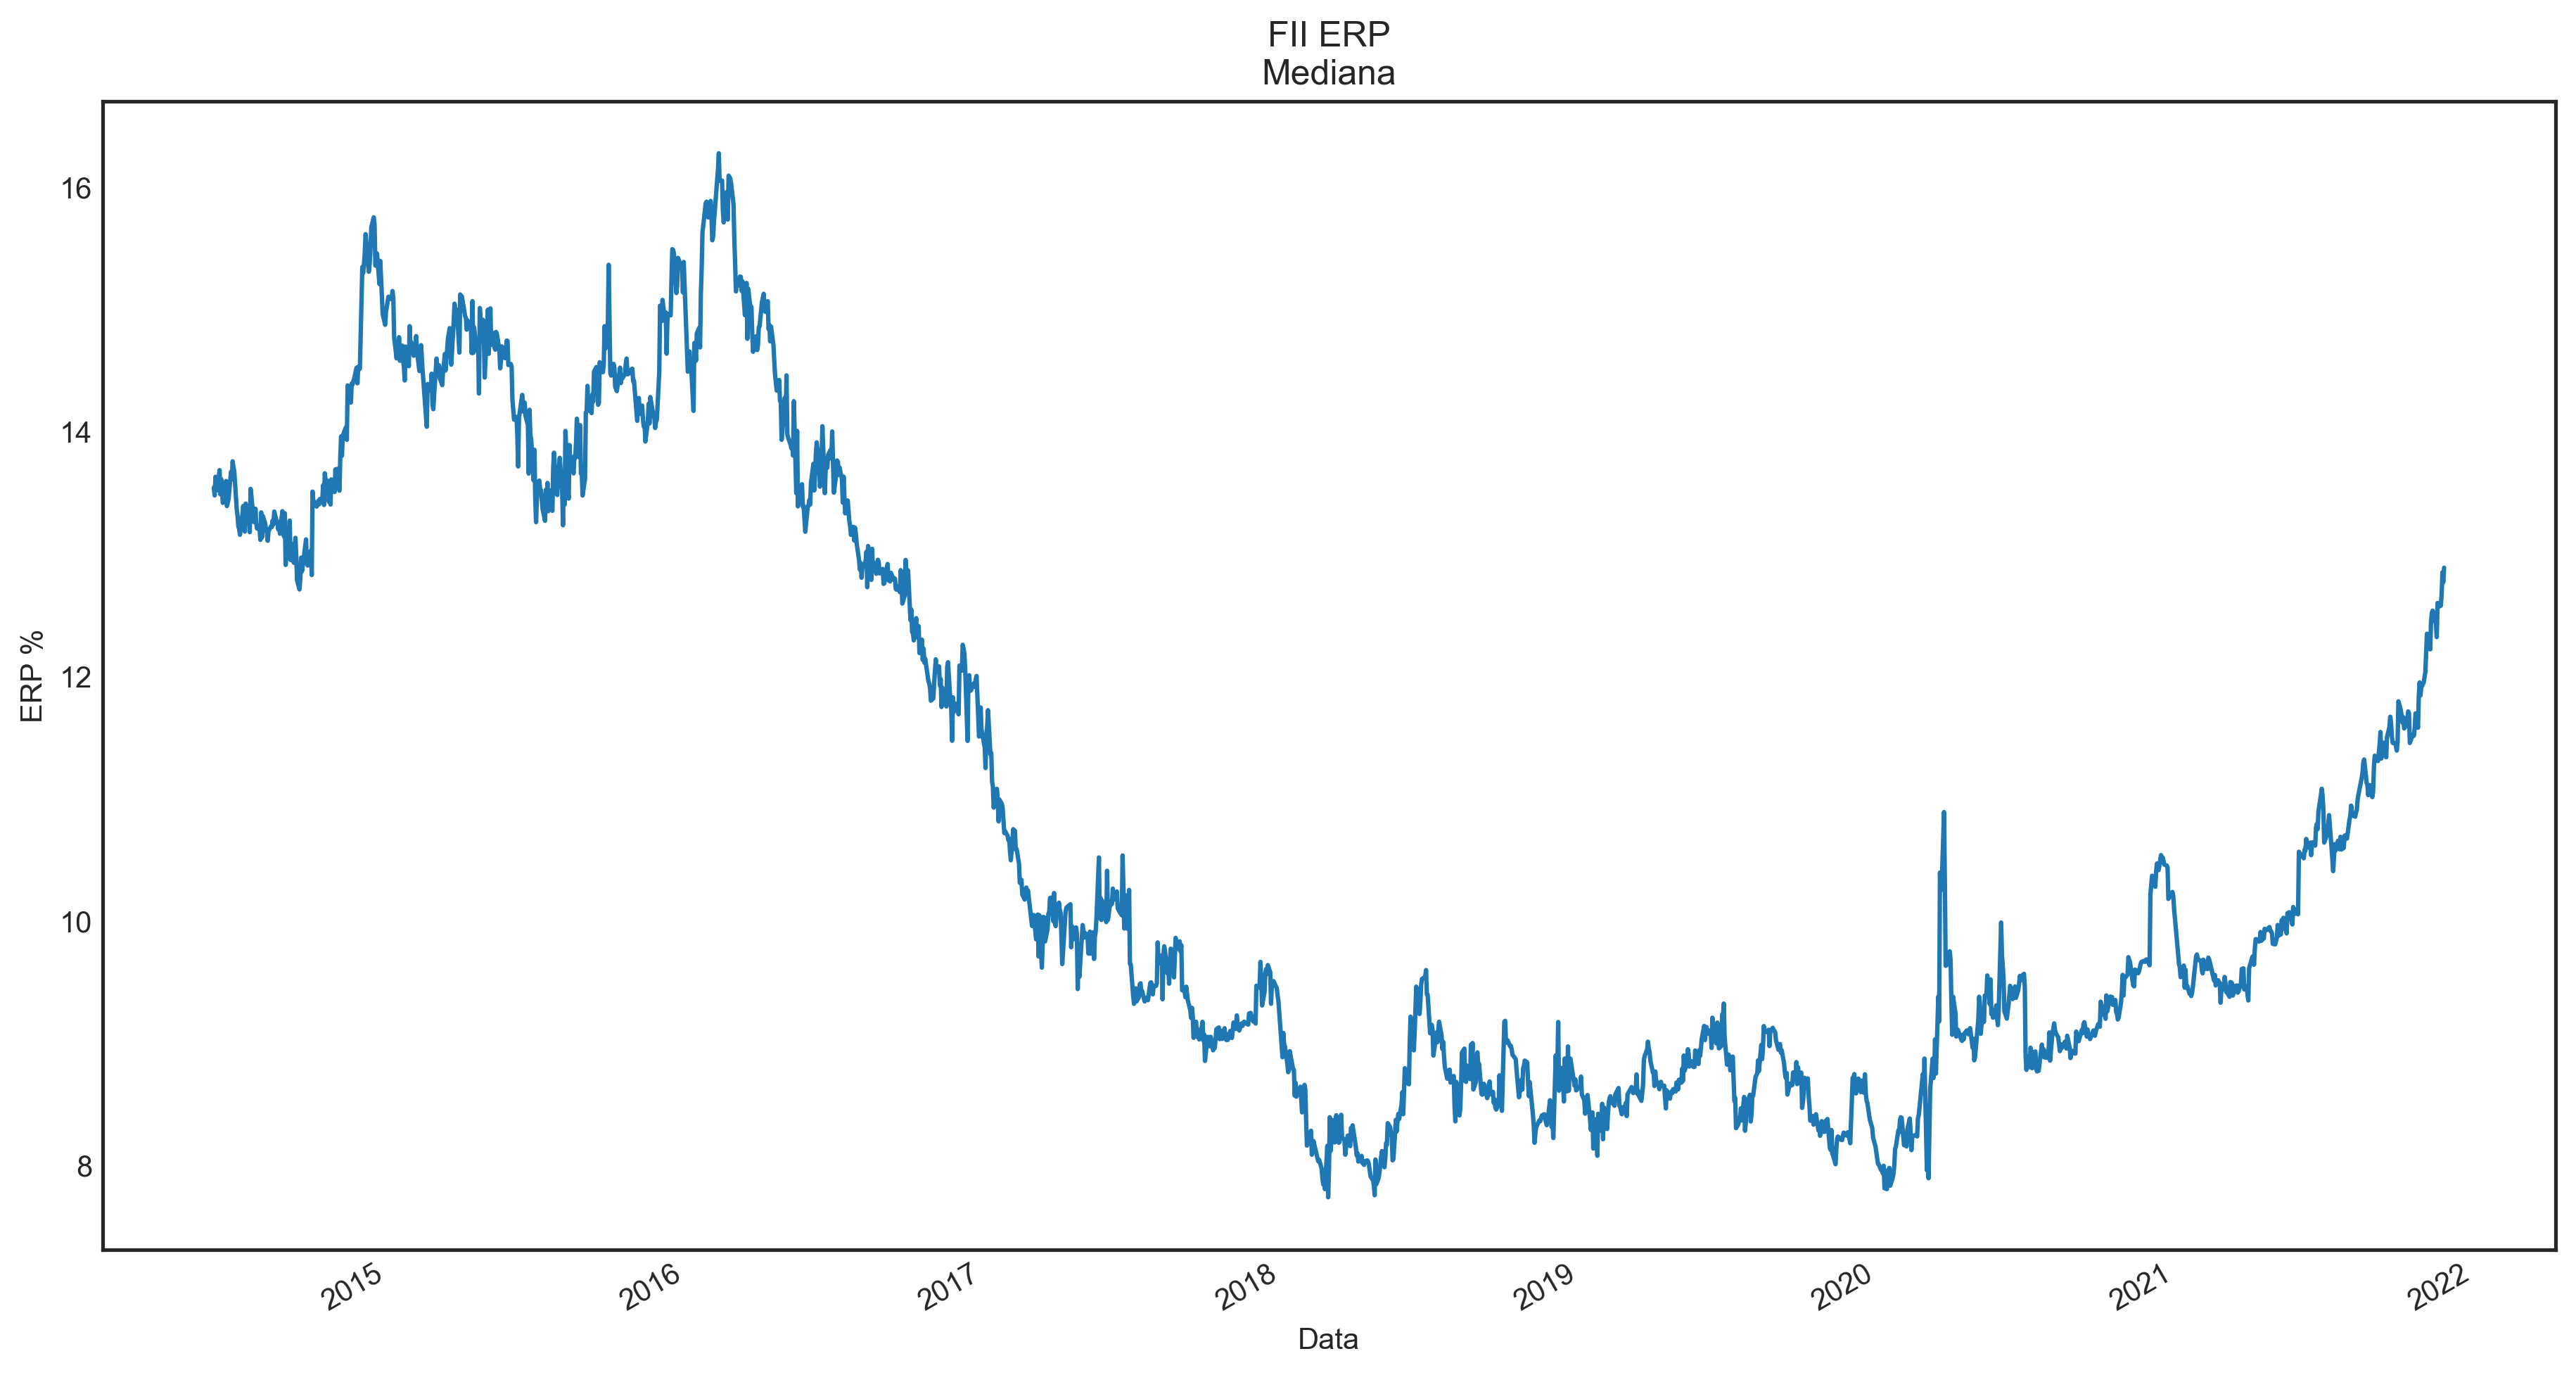

In [564]:
(ERP_df['ERP'] * 100).plot(title='FII ERP\nMediana')
plt.ylabel('ERP %')

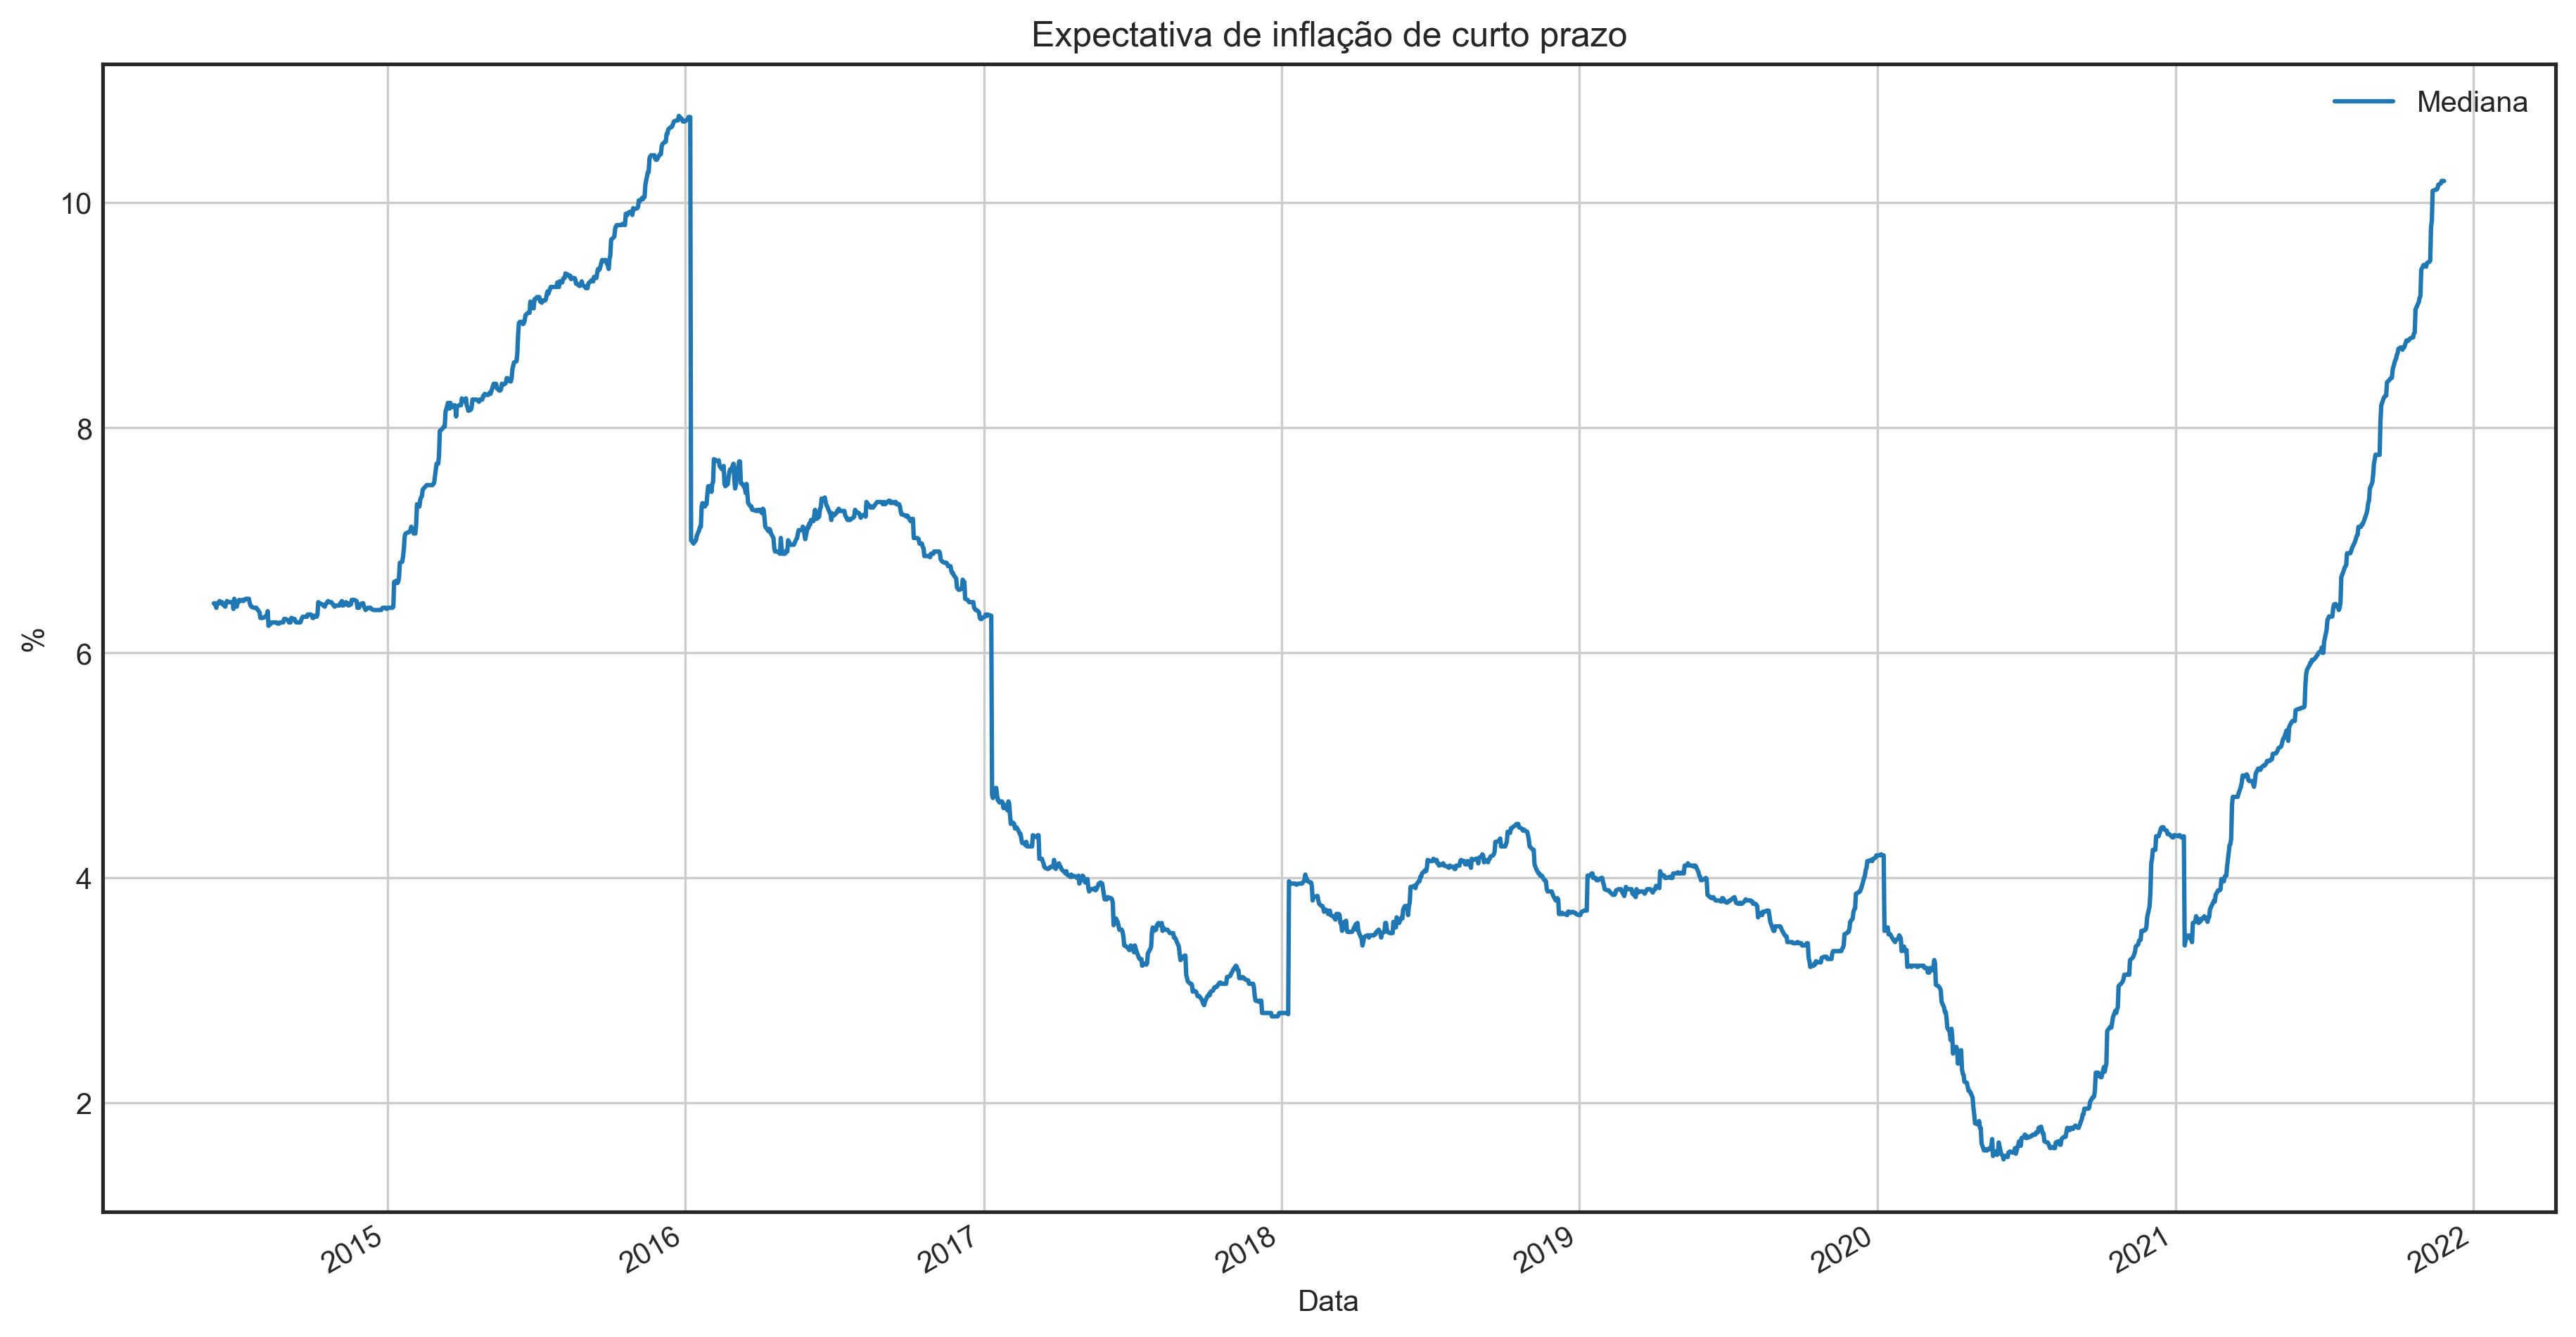

In [578]:
g0.set_index('Data').plot(title='Expectativa de inflação de curto prazo')
plt.ylabel('%')
plt.grid(True)

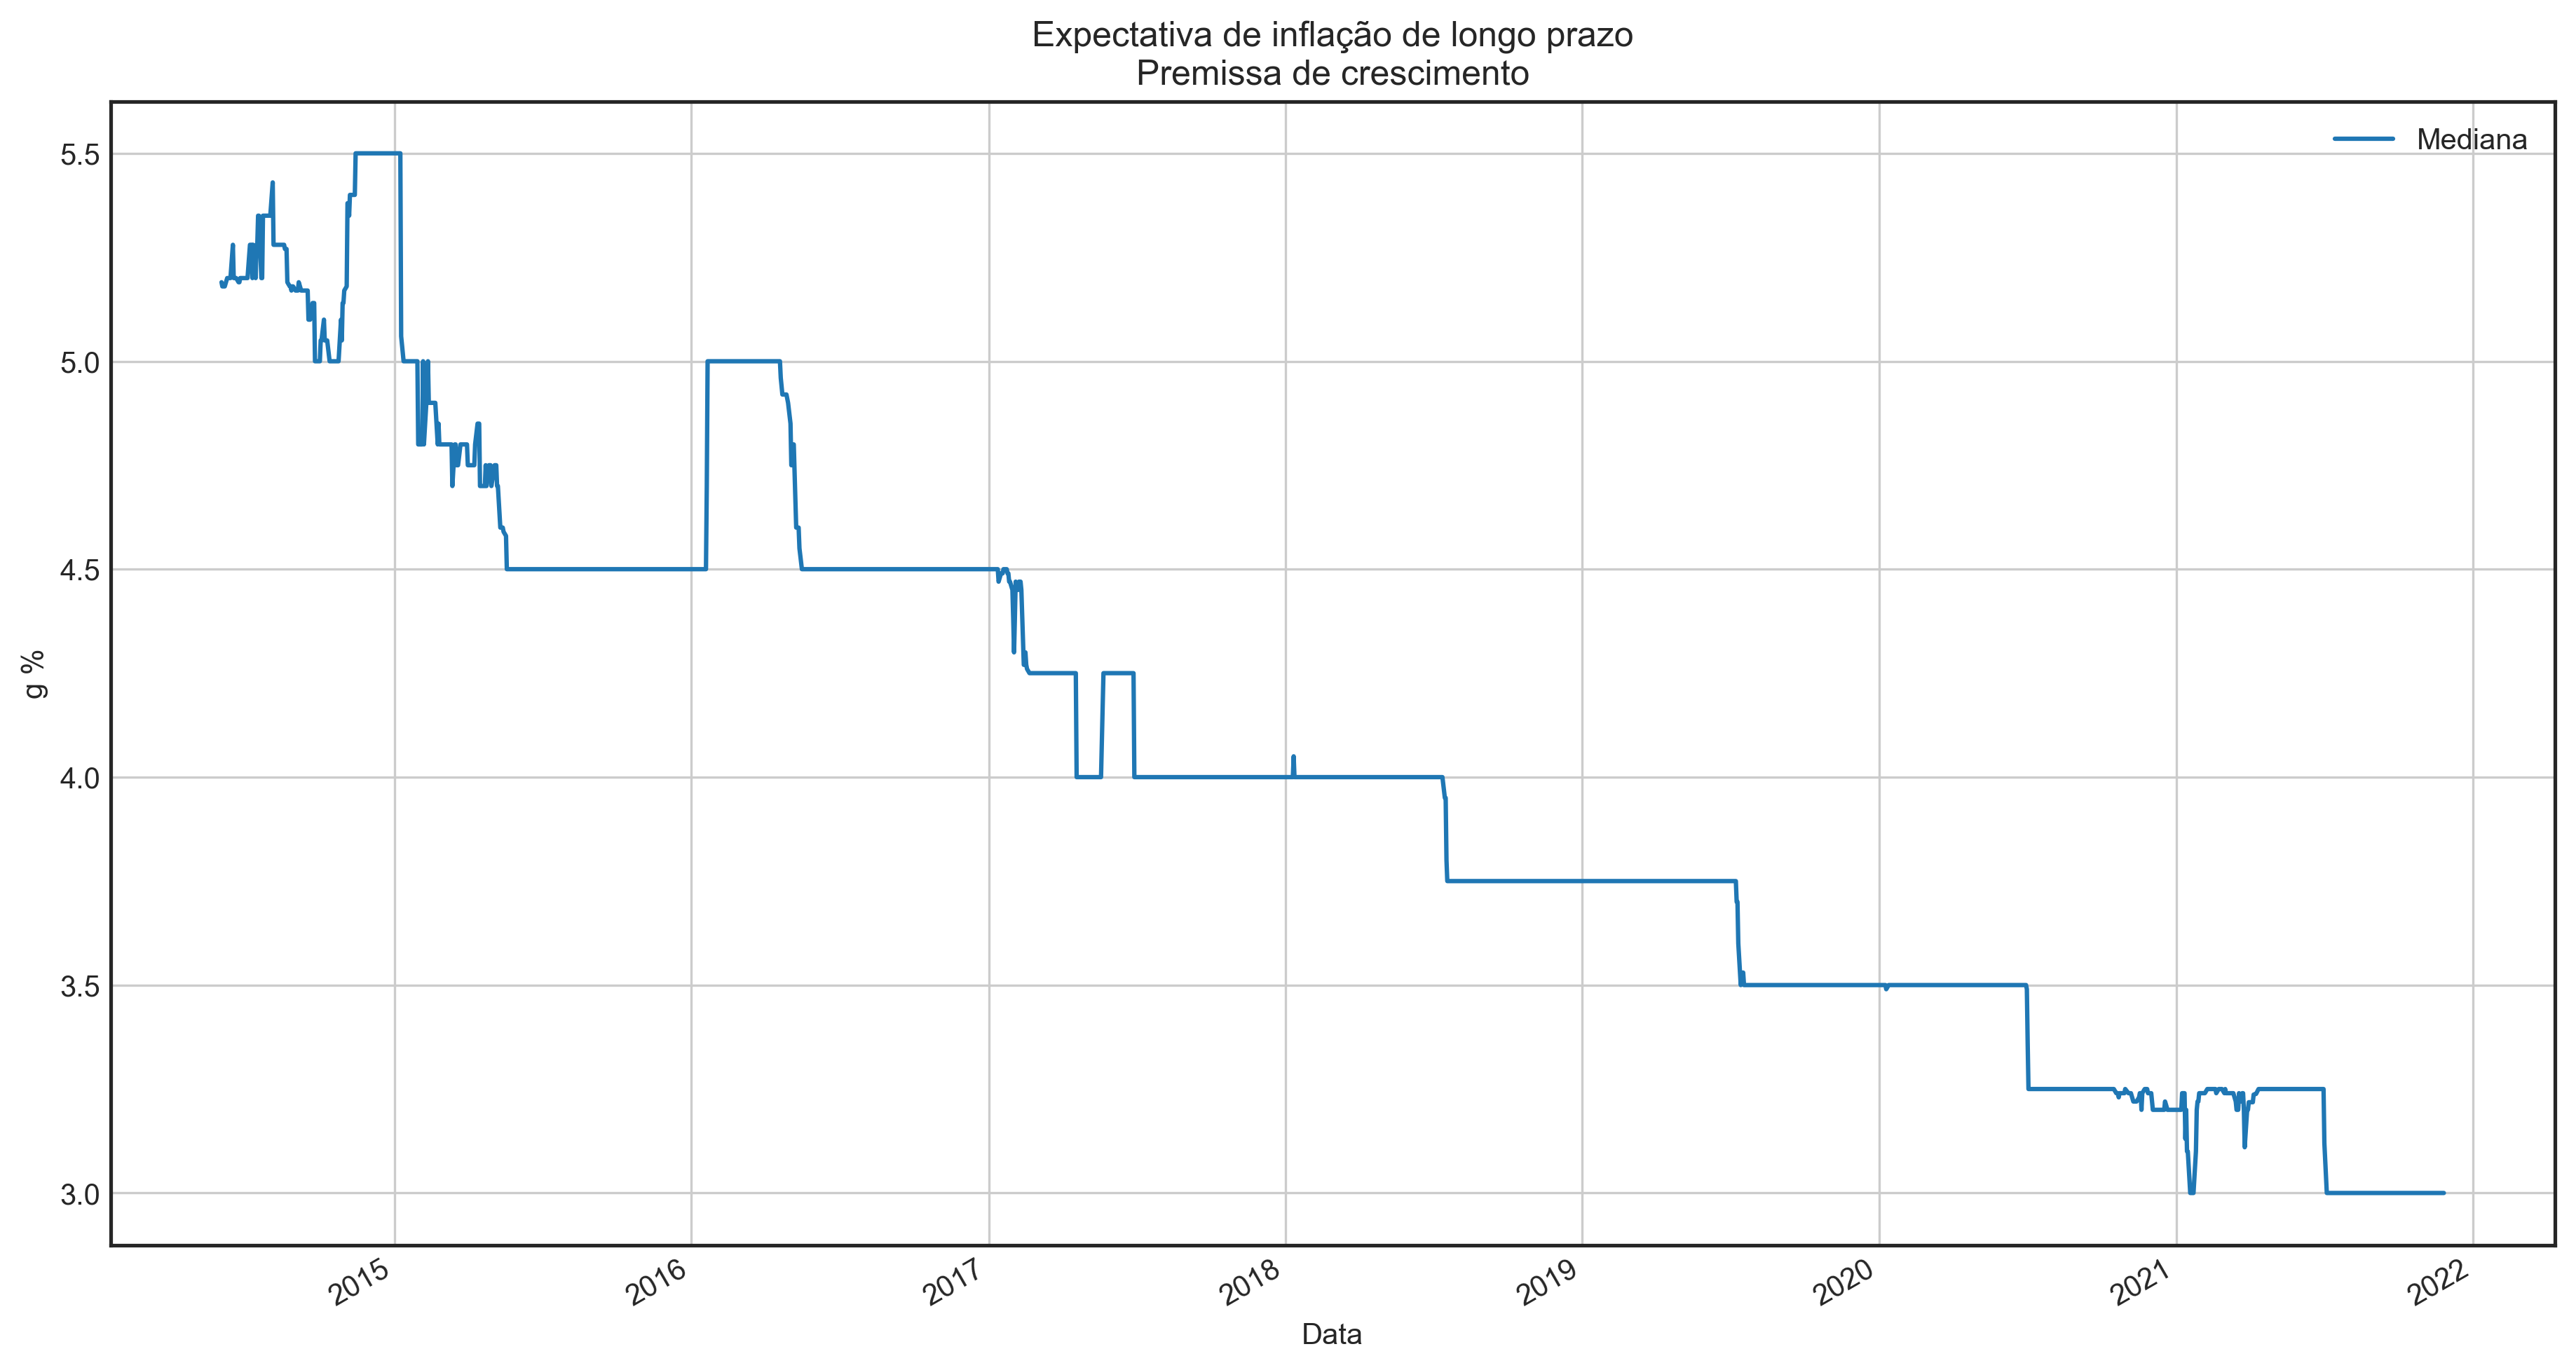

In [449]:
g.set_index('Data').plot(title='Expectativa de inflação de longo prazo\nPremissa de crescimento')
plt.ylabel('g %')
plt.grid(True)

$$V_0 = \frac{D_1}{k_e - g}$$
$$k_e = \frac{D_1}{V_0} + g$$

In [566]:
erp_fgv = pd.read_excel('serie_de_equity_risk_premium_1.xls')
erp_fgv = erp_fgv.rename(columns={'MÊS': 'Data'}).iloc[:, :2].set_index('Data')

Text(0, 0.5, '%')

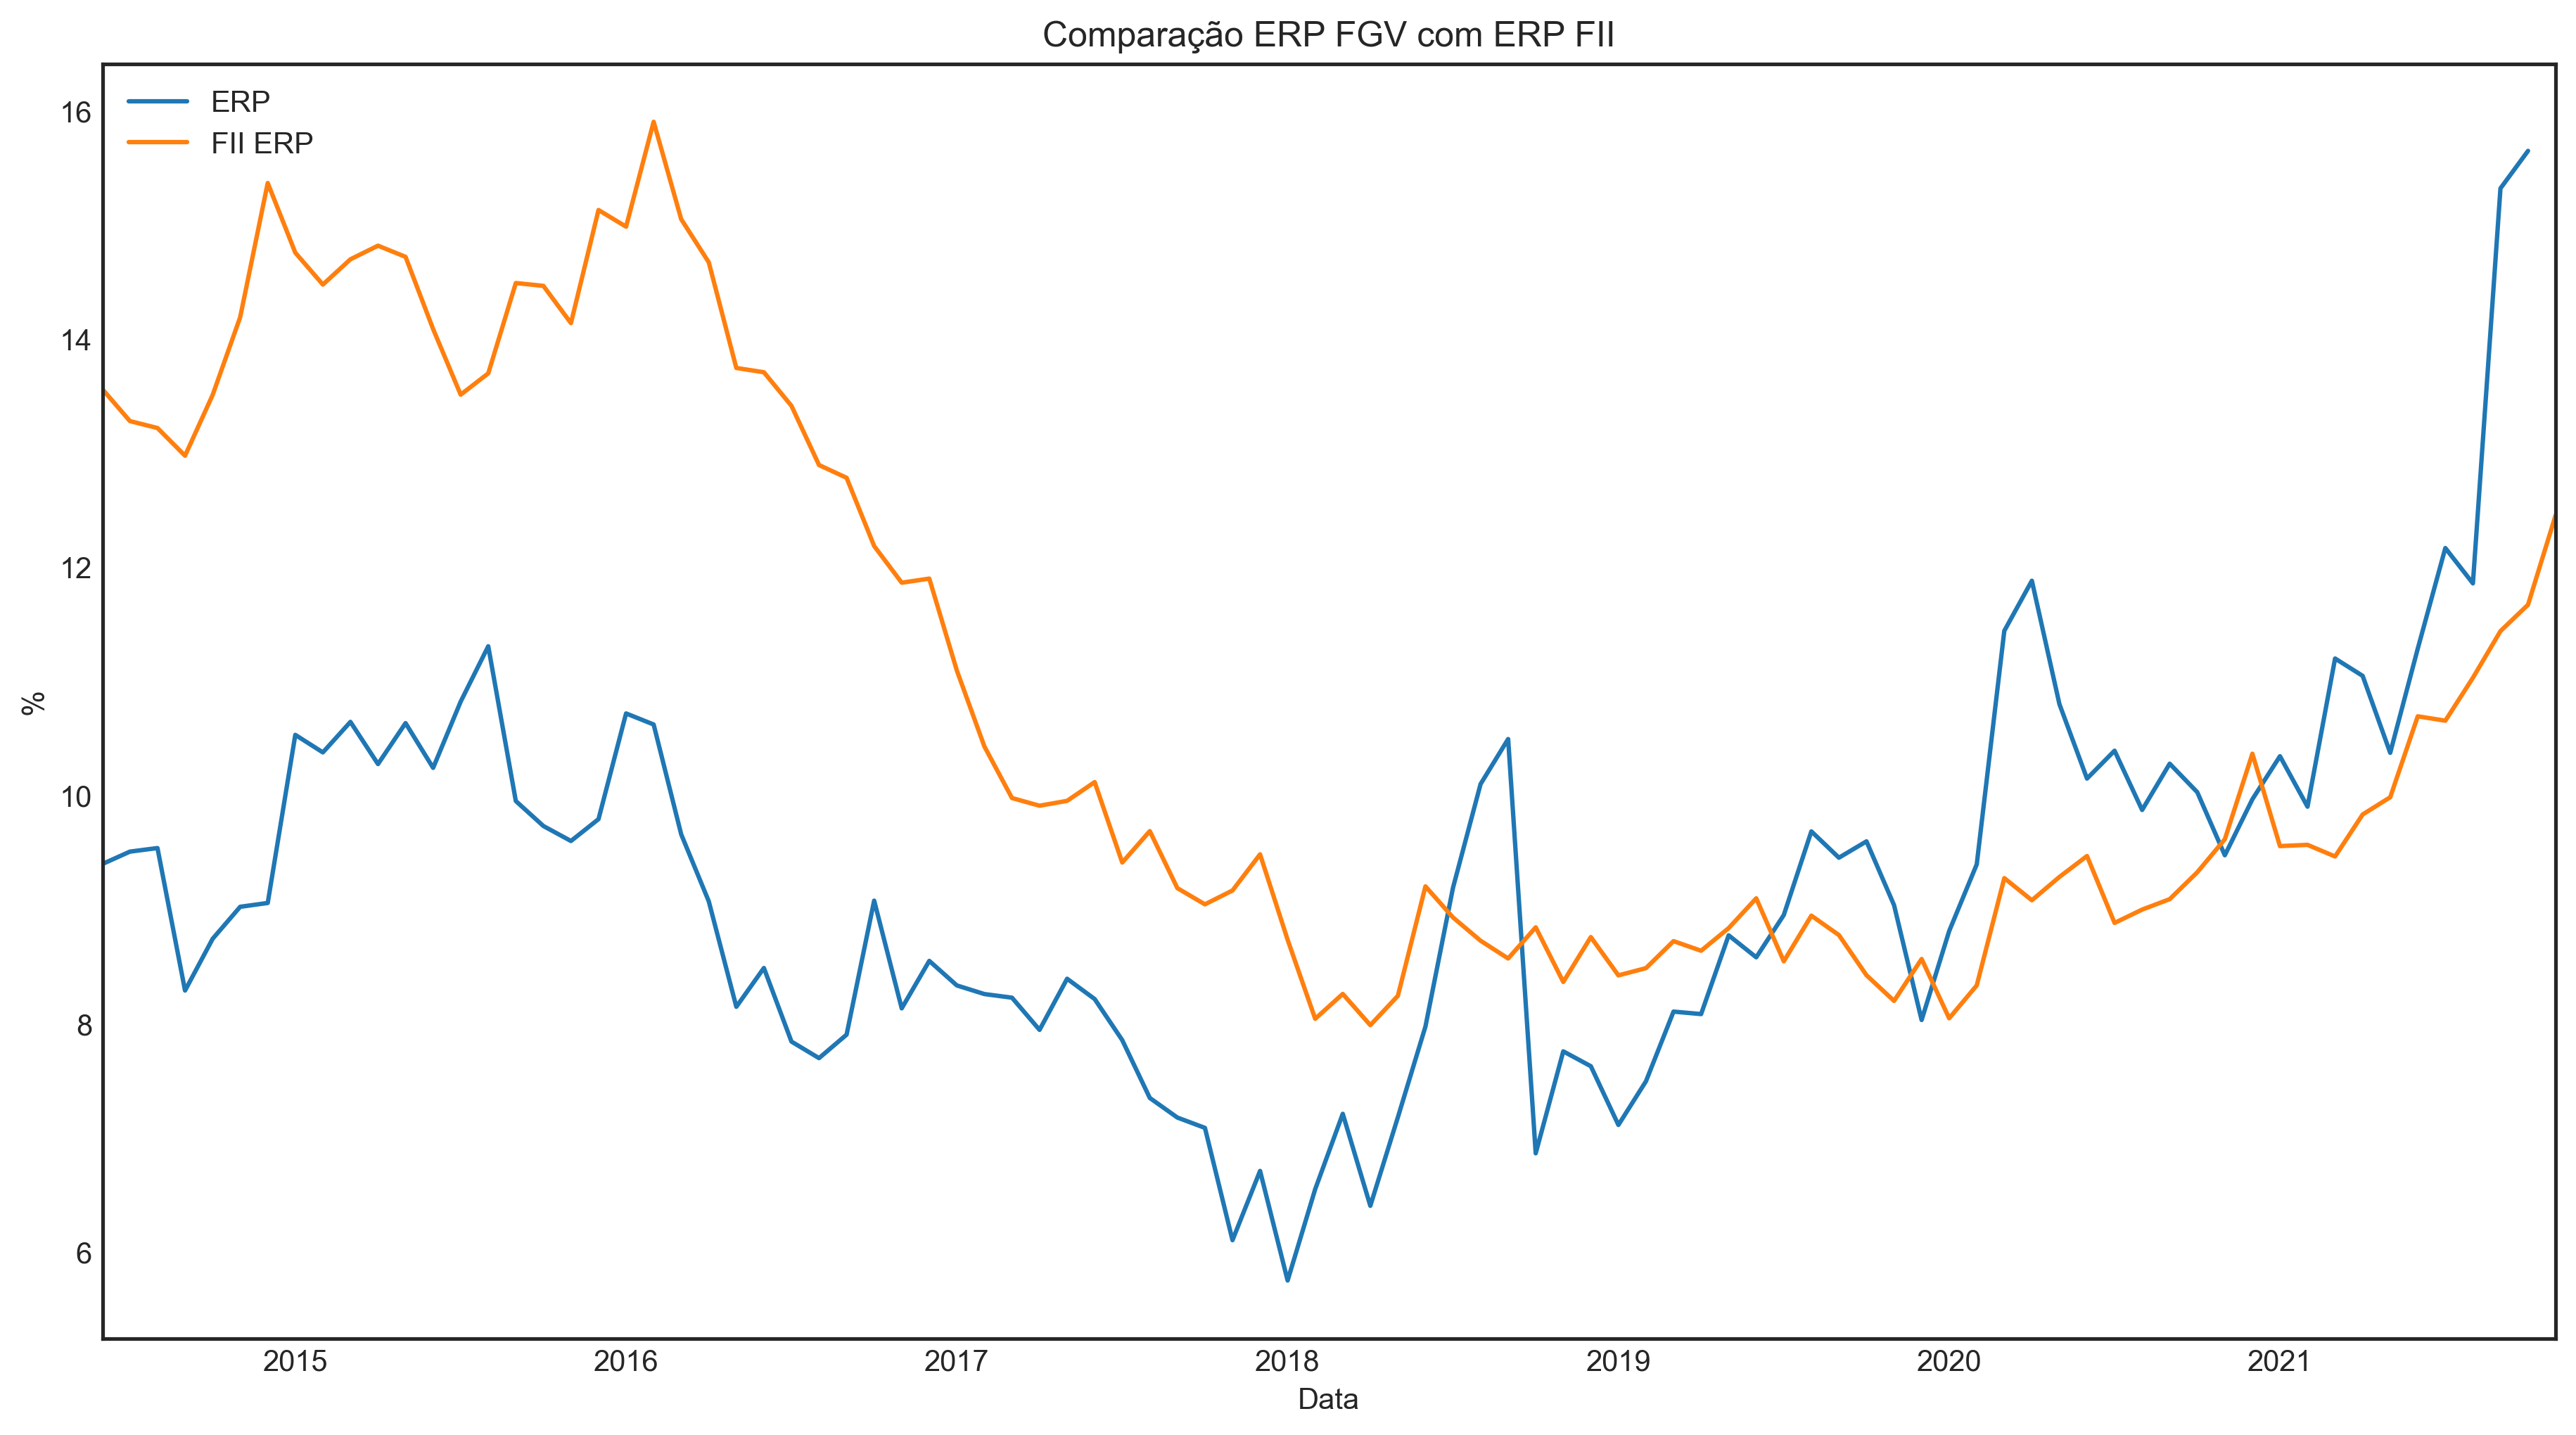

In [568]:
(erp_fgv * 100).loc['2014-06':].plot(label='ERP FGV', legend=True, title='Comparação ERP FGV com ERP FII')
(ERP_df['ERP'] * 100).groupby(pd.Grouper(freq='m')).mean().loc['2014-06':].plot(label='FII ERP', legend=True)
plt.ylabel('%')

In [570]:
selic = BcBData.get_series(1178, 'selic') / 100

In [571]:
ERP_df = pd.concat([ERP_df, selic.loc['2014-06':]], axis=1).dropna()

<AxesSubplot:xlabel='Data'>

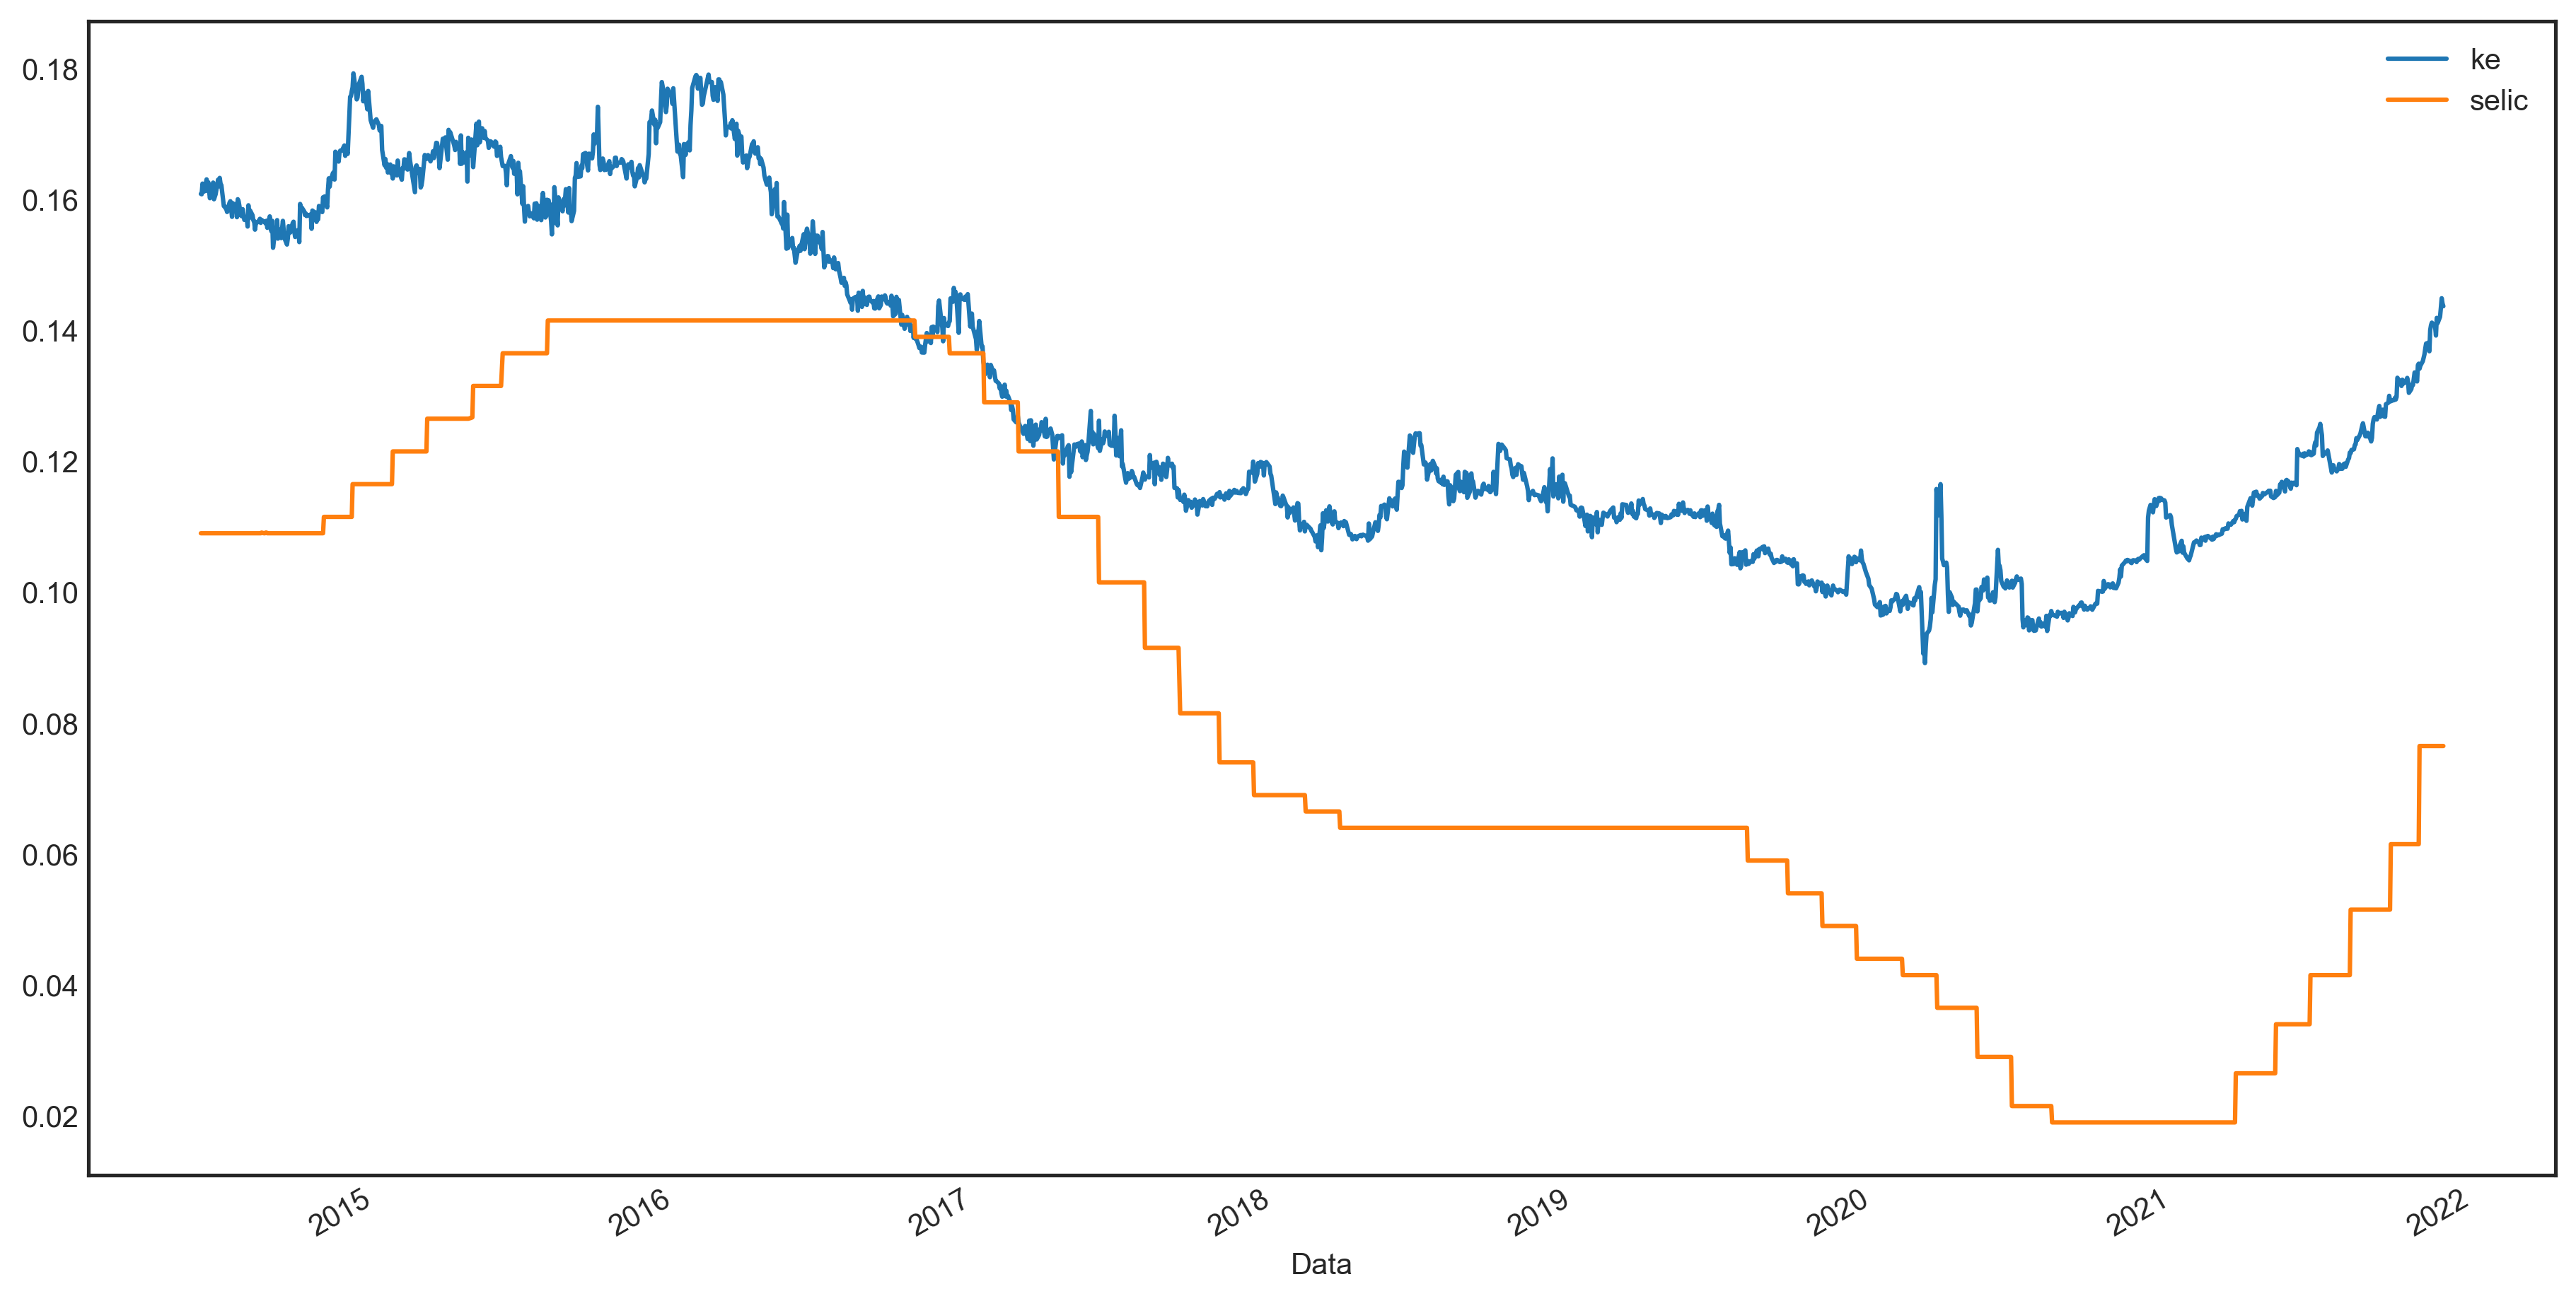

In [576]:
ERP_df[['ke', 'selic']].plot()

In [509]:
igpm = BcBData.get_series(189, 'IGP-M', start='2010')
ipca = BcBData.get_series(433, 'IPCA', start='2010')

Text(0.5, 1.0, 'IGP-M e IPCA em 12 meses')

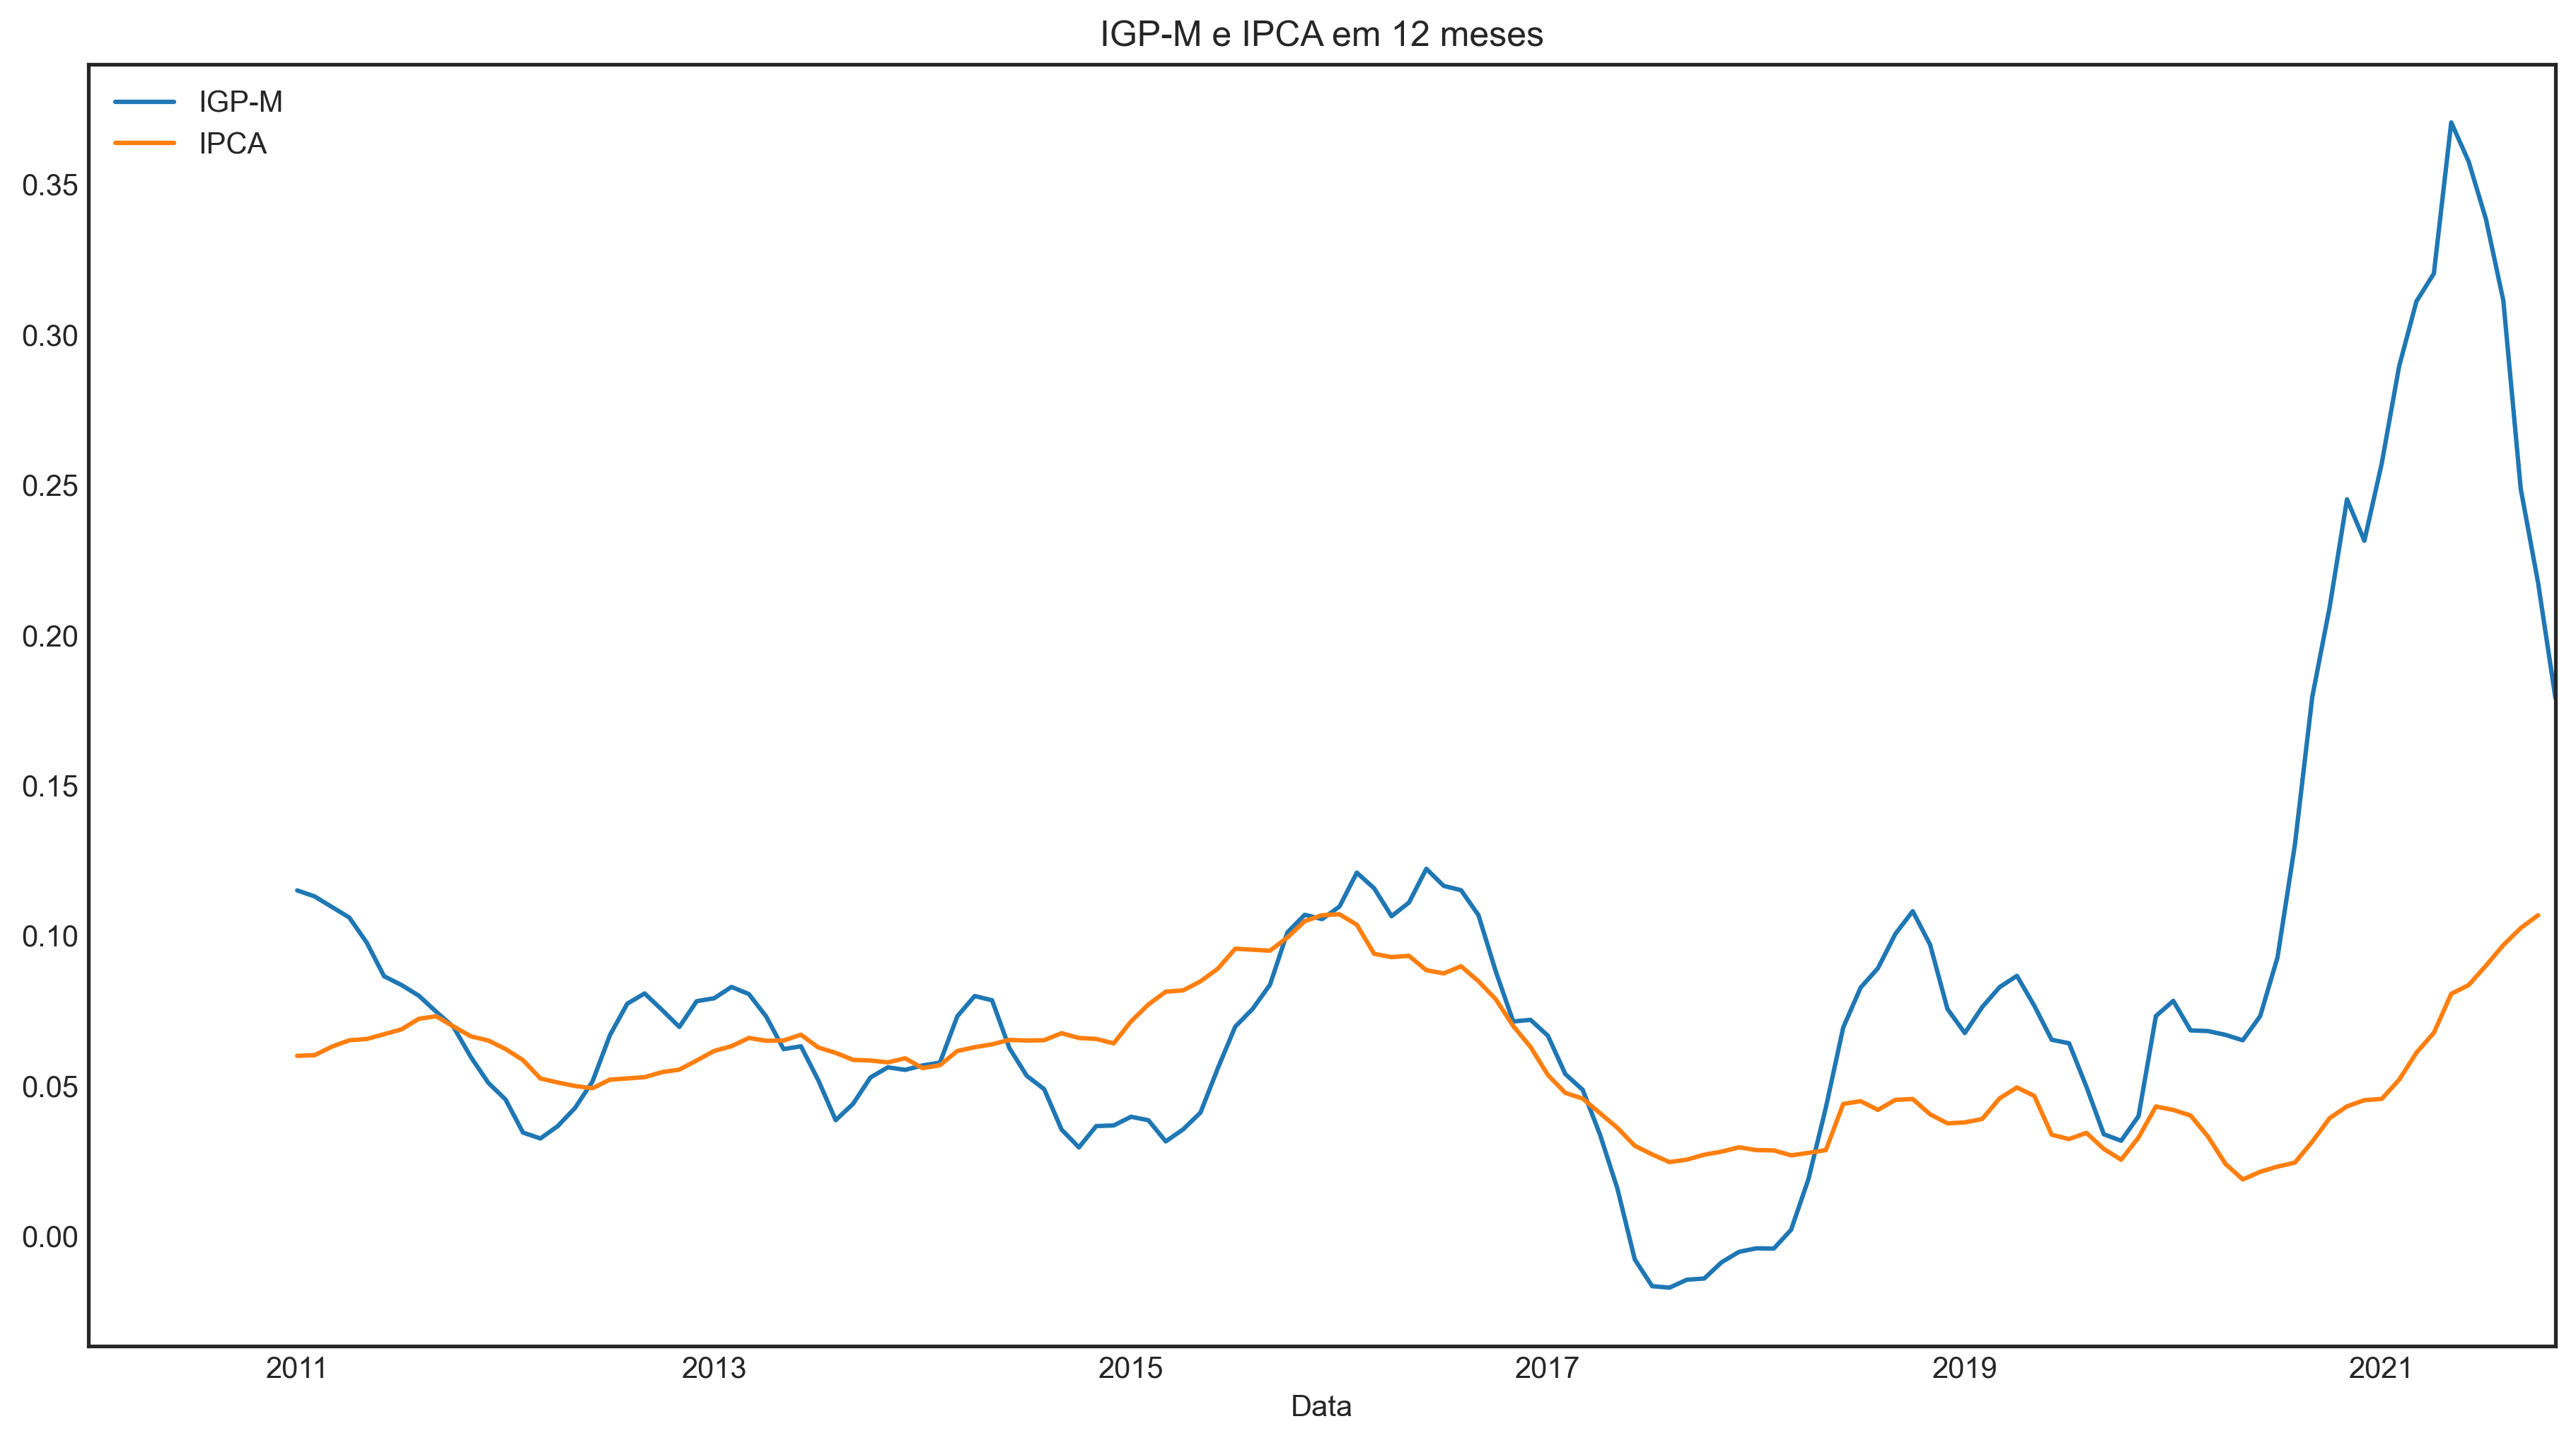

In [511]:
BcBData.mom2yoy(igpm / 100).plot(label='IGP-M', legend=True)
BcBData.mom2yoy(ipca / 100).plot(label='IPCA', legend=True)
plt.title('IGP-M e IPCA em 12 meses')

<AxesSubplot:xlabel='Data'>

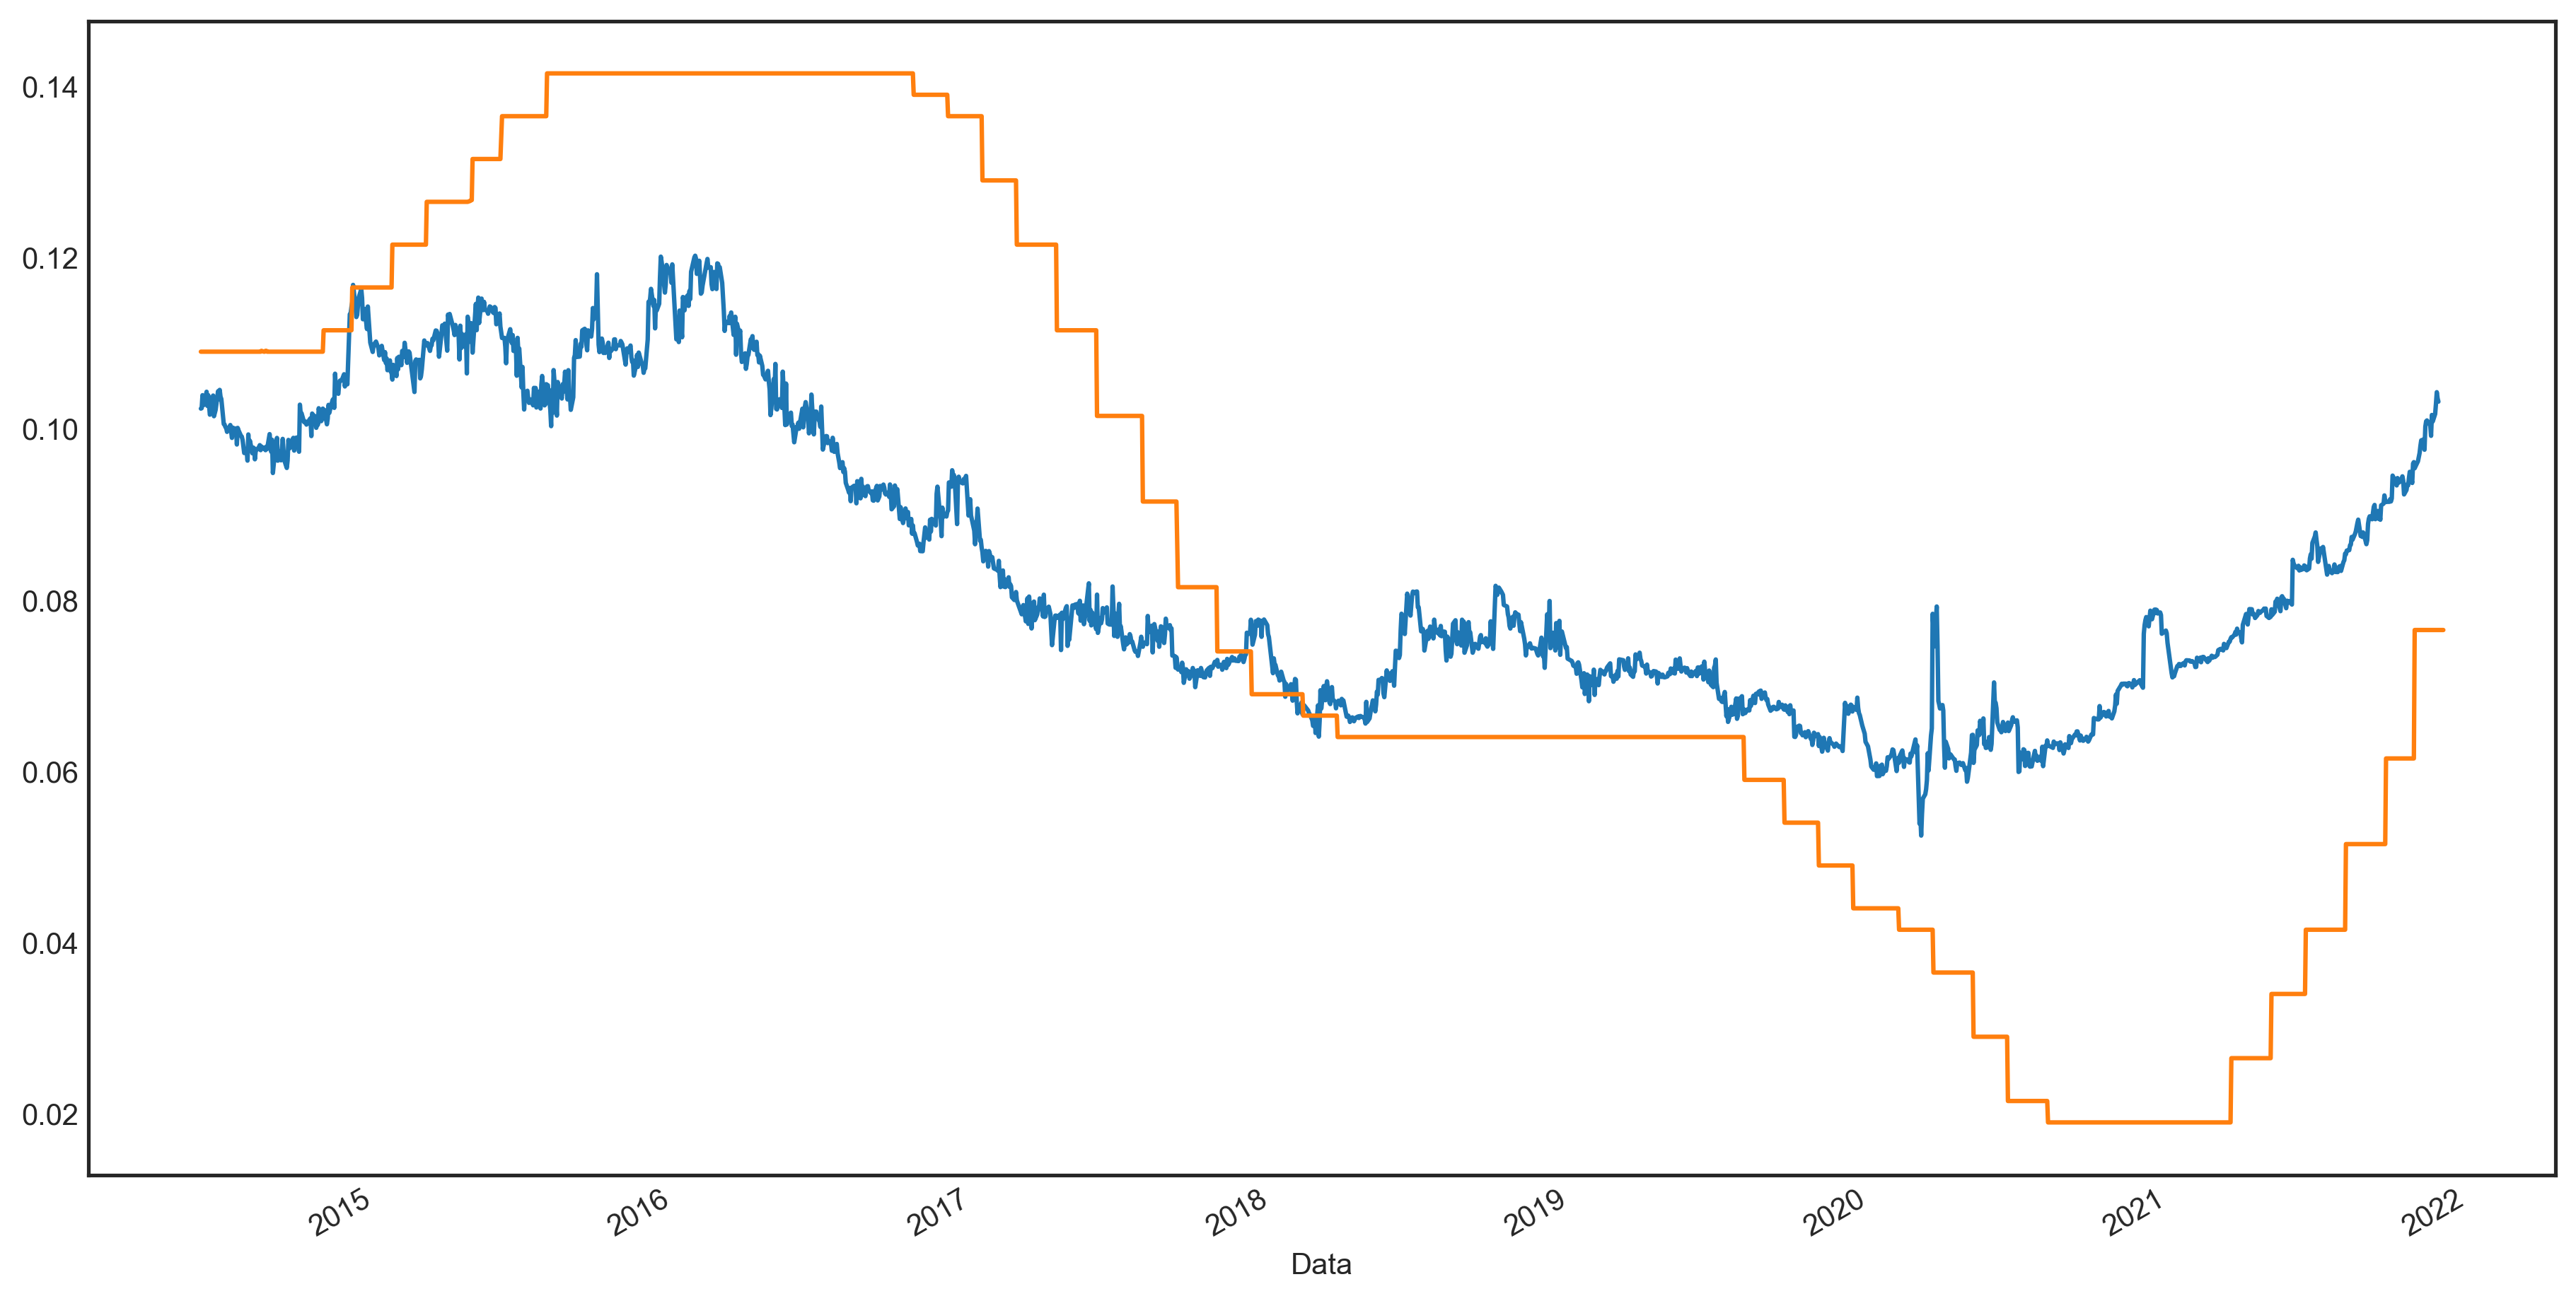

In [575]:
(divs / V0).median(1).plot()
(selic).loc['2014-06':].plot()

Text(0, 0.5, 'R$')

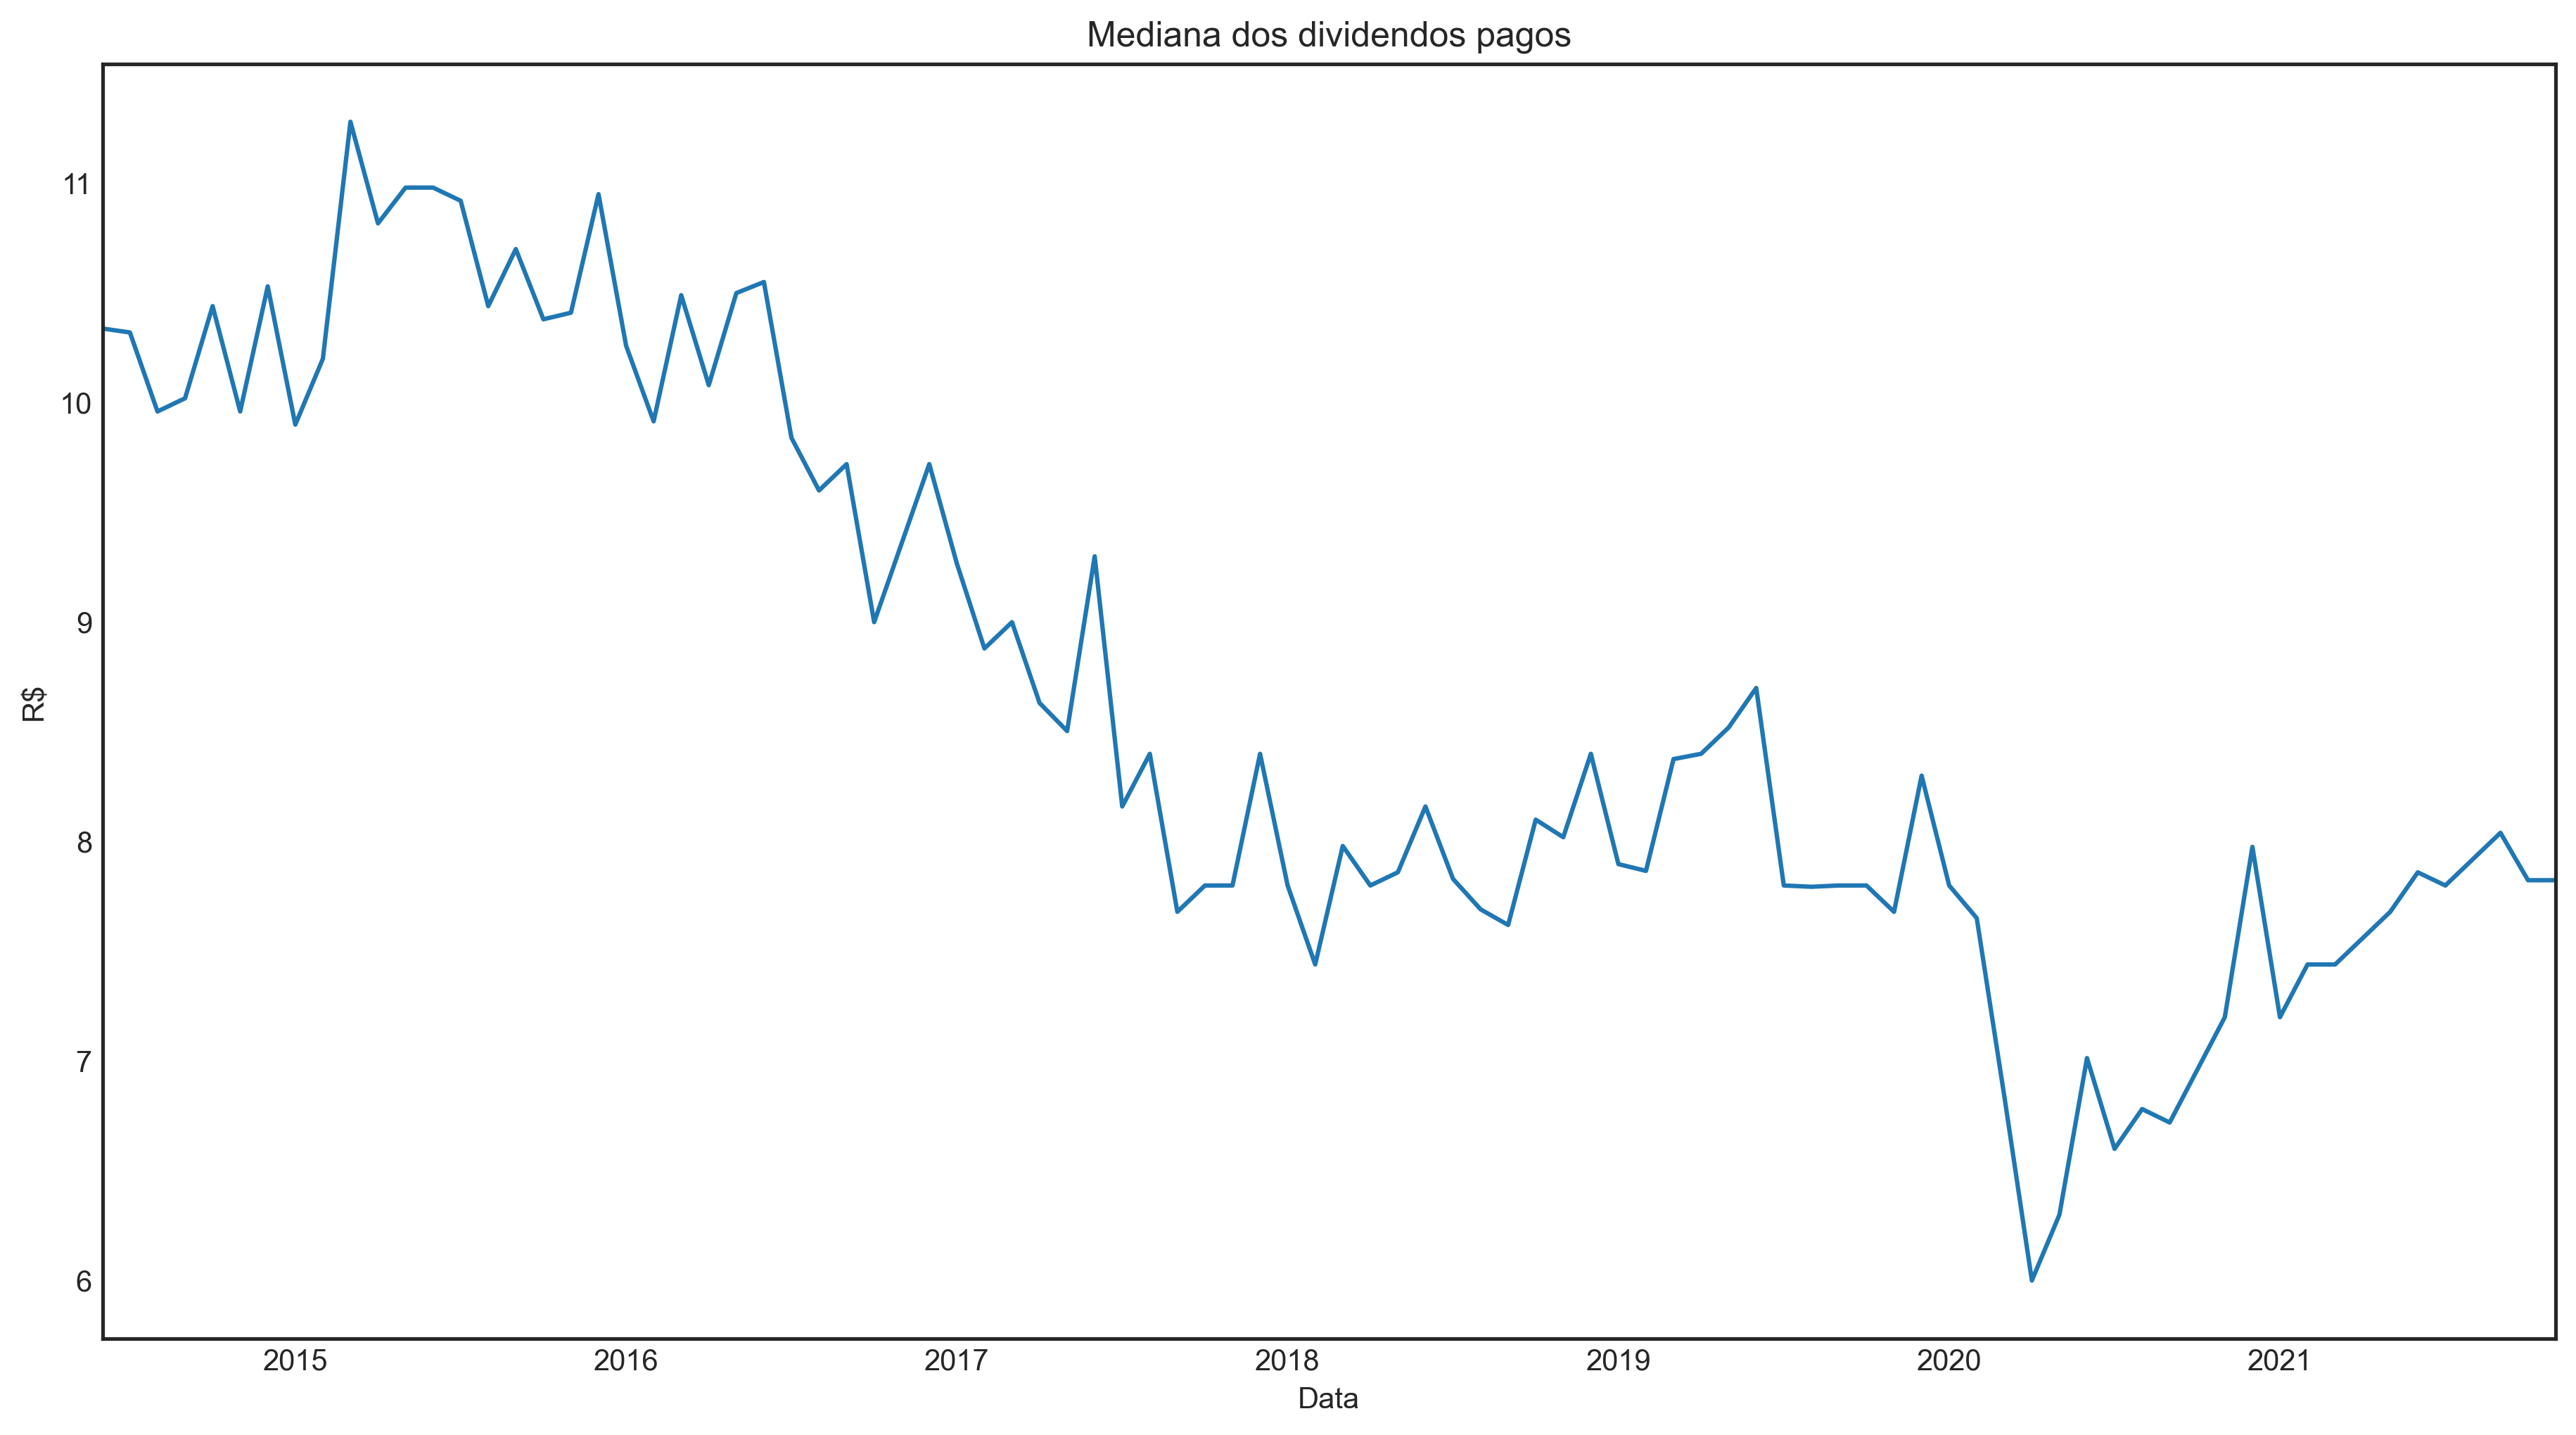

In [593]:
divs.groupby(pd.Grouper(freq='m')).mean().median(1).plot(title='Mediana dos dividendos pagos')
plt.ylabel('R$')